<a href="https://colab.research.google.com/github/anandarupmukherjee/RAN_anomaly_AMEST24/blob/main/AMEST24.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import os


drive.mount('/content/drive')
df = pd.read_csv('/content/drive/My Drive/BT_RAN_ANALYSIS/RAN_data.csv')
pd.set_option('display.max_colwidth', None)

Mounted at /content/drive


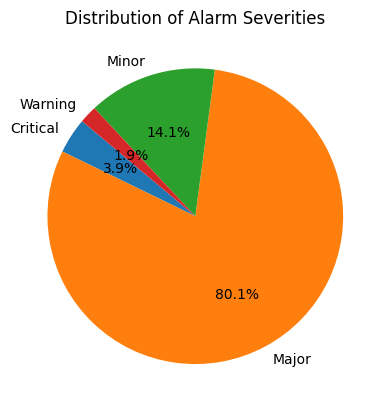

In [2]:
# pd.set_option('display.max_colwidth', None)
selected_df = df[['Alarm Source', 'Name', 'Severity', 'Hours_since_samealarm', 'Next_Alarm']]
# selected_df
unique_alarms_count = selected_df['Name'].nunique()
severity_group = selected_df.groupby('Severity').size()

# (unique_alarms_count, severity_group)


# Plotting a pie chart for the severity types
severity_group.plot(kind='pie', autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Alarm Severities')
plt.ylabel('')  # Hide y-label
plt.show()

<ipython-input-3-0461f565b34d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_df.loc[:, 'Alarm_Number'] = selected_df['Name'].map(alarm_name_to_number)
<ipython-input-3-0461f565b34d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_df.loc[:, 'Next_Alarm_Number'] = selected_df['Next_Alarm'].map(alarm_name_to_number)


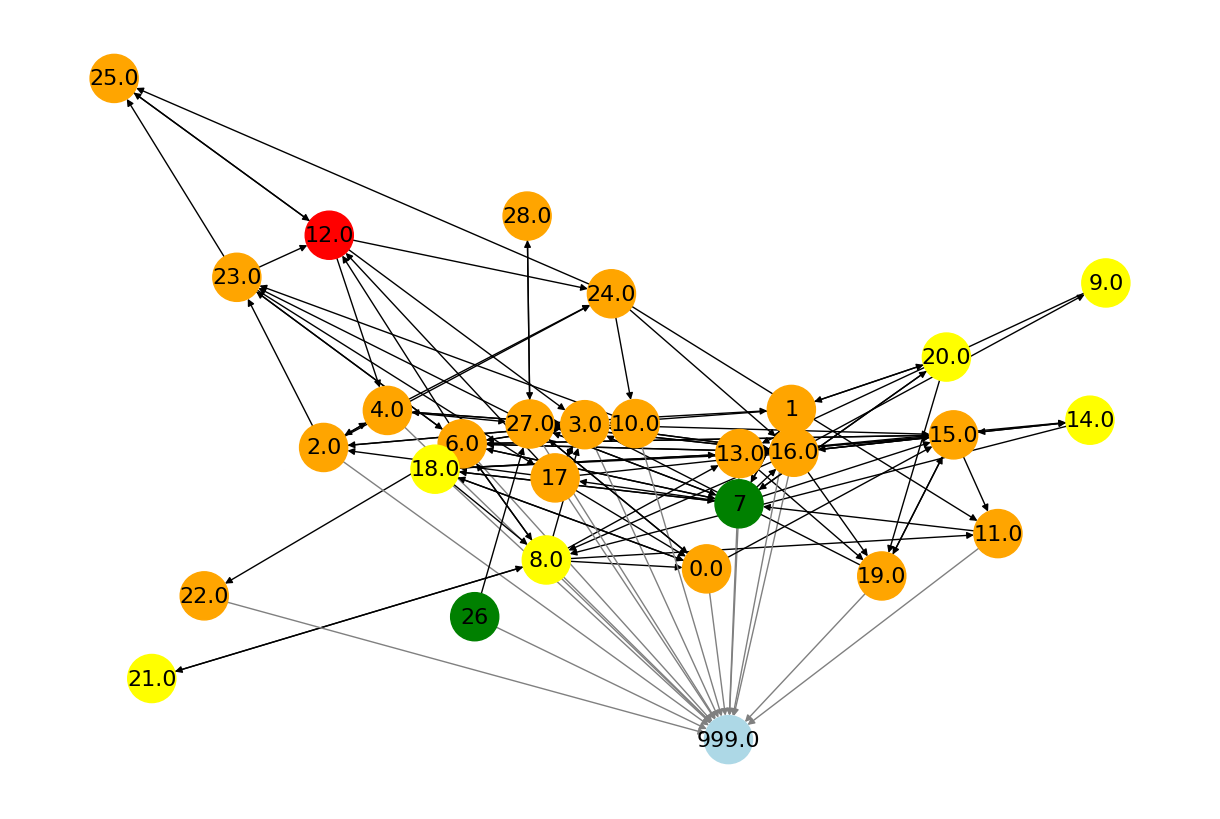

In [3]:
alarm_name_to_number = pd.Series(pd.factorize(selected_df['Name'])[0], index=selected_df['Name']).to_dict()

selected_df.loc[:, 'Alarm_Number'] = selected_df['Name'].map(alarm_name_to_number)

selected_df.loc[:, 'Next_Alarm_Number'] = selected_df['Next_Alarm'].map(alarm_name_to_number)

# Assign 999 to 'Next_Alarm_Number' where 'Next_Alarm' is "Noalarm"
no_alarm_identifier = "Noalarm"  # Replace this with the exact string used in your DataFrame
selected_df.loc[selected_df['Next_Alarm'] == no_alarm_identifier, 'Next_Alarm_Number'] = 999

bs=df.loc[:,'Alarm Source'].unique()
# filtered_df = selected_df[selected_df['Alarm Source'] == bs[4]]
# filtered_df

bs_values = [bs[i] for i in range(1, 5)]  # Selecting values from 1 to 8 from bs

# Filter the DataFrame for rows where 'Alarm Source' is in the list of selected bs values
filtered_df = selected_df[selected_df['Alarm Source'].isin(bs_values)]

# Create an empty directed graph
G = nx.DiGraph()

# Add edges from Alarm_Number to Next_Alarm_Number
for _, row in filtered_df.iterrows():
    G.add_edge(row['Alarm_Number'], row['Next_Alarm_Number'])


# Mapping of alarm names to their severities
name_to_severity = pd.Series(selected_df['Severity'].values, index=selected_df['Name']).to_dict()

# Mapping alarm numbers to their severities
number_to_severity = {alarm_name_to_number[name]: name_to_severity[name] for name in alarm_name_to_number}

# Color mapping based on severity
severity_colors = {'Critical': 'red', 'Major': 'orange', 'Minor': 'yellow', 'Warning': 'green', 'Noalarm': 'lightblue'}

# Assign colors to nodes based on their severity
node_colors = [severity_colors[number_to_severity.get(node, 'Noalarm')] for node in G.nodes()]

# Define edge colors
edge_colors = ['black' if edge[1] != 999 else 'gray' for edge in G.edges()]

# Set the size of the plot and draw the graph
plt.figure(figsize=(12, 8))
nx.draw(G, with_labels=True, node_color=node_colors, edge_color=edge_colors, node_size=1200, font_size=16)
plt.show()

# Graphing BS Specific alarm relationships and color coded severity of **alarms**

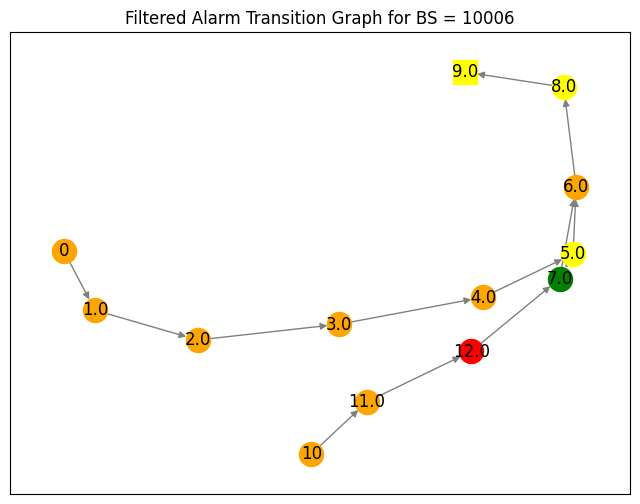

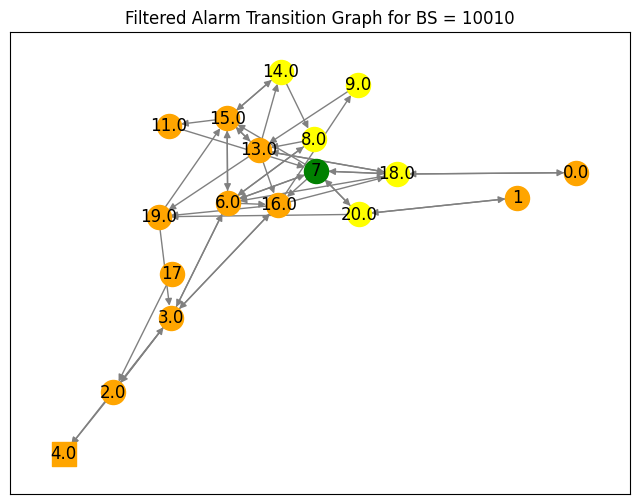

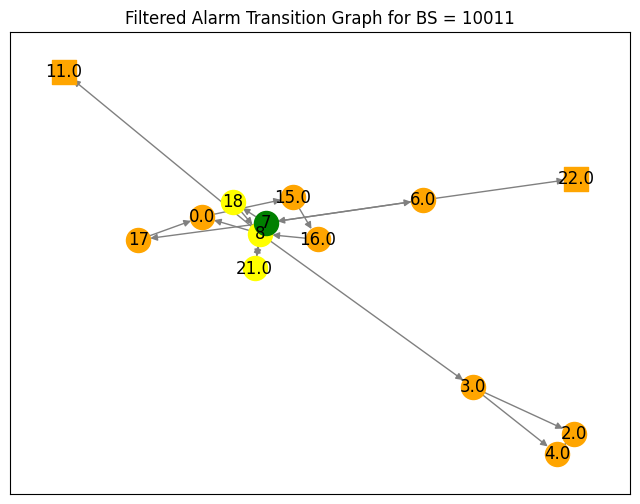

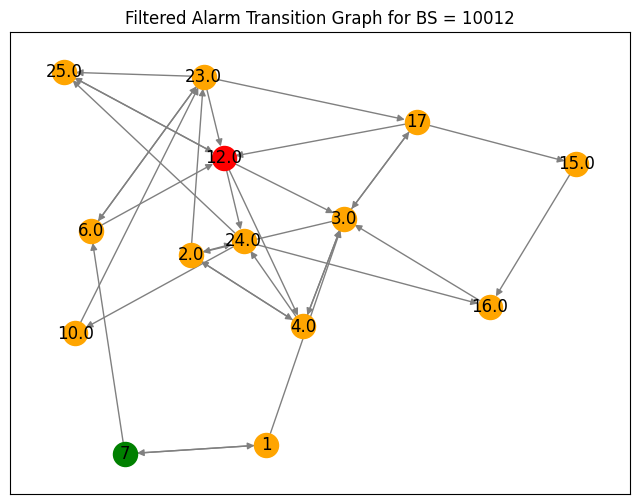

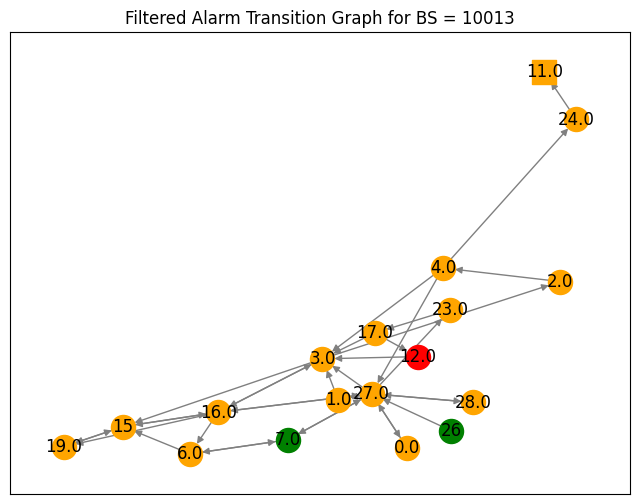

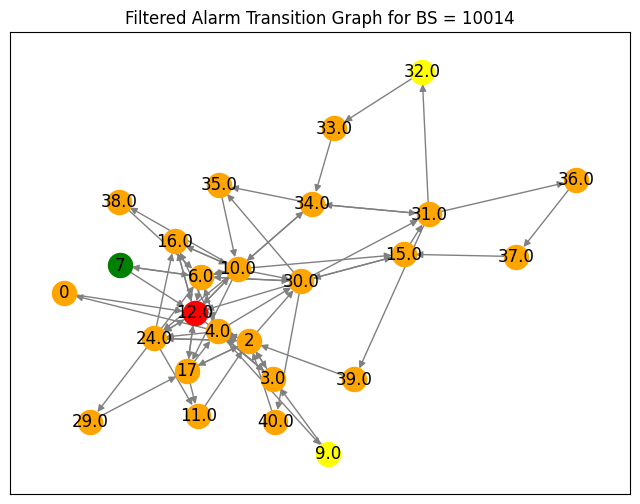

In [5]:
bs=df.loc[:,'Alarm Source'].unique()

# Use factorize to assign numbers to unique alarm names
labels, unique_values = pd.factorize(df['Name'])

# Map each alarm in the DataFrame to its assigned number
mapped_labels = labels[df['Name'].index]

# Create a DataFrame from the unique alarm names and their corresponding labels
alarm_name_number_df = pd.DataFrame({
    'Alarm_Name': df['Name'],
    'Alarm_Number': mapped_labels,
    'Severity': df['Severity']
})

# Dropping duplicates to have a unique mapping
alarm_name_number_df = alarm_name_number_df.drop_duplicates(subset=['Alarm_Name']).reset_index(drop=True)

os.makedirs('saved_graphs', exist_ok=True)

graph_data=[]

# Mapping of alarm numbers to their severities
number_to_severity = pd.Series(alarm_name_number_df['Severity'].values, index=alarm_name_number_df['Alarm_Number']).to_dict()

# Color mapping based on severity
severity_colors = {'Critical': 'red', 'Major': 'orange', 'Minor': 'yellow', 'Warning': 'green', 'Noalarm': 'lightblue'}

for i in range(0, 6):
    G_filtered = nx.DiGraph()
    filtered_df = selected_df[selected_df['Alarm Source'] == bs[i]]

    for _, row in filtered_df.iterrows():
        if row['Next_Alarm_Number'] != 999:
            G_filtered.add_edge(row['Alarm_Number'], row['Next_Alarm_Number'])

    # Save the graph to disk
    graph_filename = f'saved_graphs/graph_{i}.gml'
    nx.write_gml(G_filtered, graph_filename)

    graph_data.append(graph_filename)

    # Define node colors based on severity and node shapes based on out-degree
    node_colors = [severity_colors.get(number_to_severity.get(node, 'Noalarm'), 'lightblue') for node in G_filtered.nodes()]
    node_shapes = ['s' if G_filtered.out_degree(n) == 0 else 'o' for n in G_filtered.nodes()]

    # Visualize the graph with different node shapes
    plt.figure(figsize=(8, 6))  # Adjust the size as needed
    pos = nx.spring_layout(G_filtered)  # Position layout for nodes

    for node, shape in zip(G_filtered.nodes, node_shapes):
        nx.draw_networkx_nodes(G_filtered, pos=pos, nodelist=[node],
                               node_color=[node_colors[list(G_filtered.nodes).index(node)]],
                               node_shape=shape)

    nx.draw_networkx_edges(G_filtered, pos=pos, edge_color='gray')
    nx.draw_networkx_labels(G_filtered, pos=pos, font_size=12)

    plt.title(f'Filtered Alarm Transition Graph for BS = {bs[i]}')
    plt.show()

# **Counting base station wise count of nodes with their in-degrees **

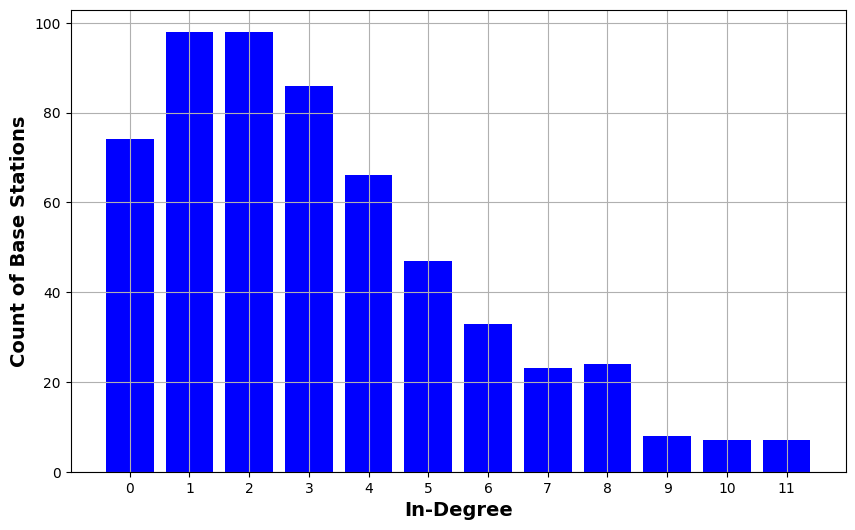

In [6]:
bs=df.loc[:,'Alarm Source'].unique()

# Use factorize to assign numbers to unique alarm names
labels, unique_values = pd.factorize(df['Name'])

# Map each alarm in the DataFrame to its assigned number
mapped_labels = labels[df['Name'].index]

# Create a DataFrame from the unique alarm names and their corresponding labels
alarm_name_number_df = pd.DataFrame({
    'Alarm_Name': df['Name'],
    'Alarm_Number': mapped_labels,
    'Severity': df['Severity']
})

# Dropping duplicates to have a unique mapping
alarm_name_number_df = alarm_name_number_df.drop_duplicates(subset=['Alarm_Name']).reset_index(drop=True)

os.makedirs('saved_graphs', exist_ok=True)

graph_data=[]

# Mapping of alarm numbers to their severities
number_to_severity = pd.Series(alarm_name_number_df['Severity'].values, index=alarm_name_number_df['Alarm_Number']).to_dict()

# Color mapping based on severity
severity_colors = {'Critical': 'red', 'Major': 'orange', 'Minor': 'yellow', 'Warning': 'green', 'Noalarm': 'lightblue'}

# Initialize a dictionary to store in-degree counts for each base station
bs_indegree_counts = {}

for i in range(0, 100):
    G_filtered = nx.DiGraph()
    filtered_df = selected_df[selected_df['Alarm Source'] == bs[i]]

    for _, row in filtered_df.iterrows():
        if row['Next_Alarm_Number'] != 999:
            G_filtered.add_edge(row['Alarm_Number'], row['Next_Alarm_Number'])

    # Save the graph to disk
    graph_filename = f'saved_graphs/graph_{i}.gml'
    nx.write_gml(G_filtered, graph_filename)

    graph_data.append(graph_filename)

    # Calculate in-degrees for the nodes
    in_degrees = dict(G_filtered.in_degree())
    in_degree_count = {}
    for node, in_degree in in_degrees.items():
        in_degree_count.setdefault(in_degree, 0)
        in_degree_count[in_degree] += 1

    # Store the in-degree counts for this base station
    bs_indegree_counts[bs[i]] = in_degree_count

# Aggregate in-degree counts across all base stations to count each base station only once per in-degree
aggregate_indegree_counts = {}
for bs, counts in bs_indegree_counts.items():
    for in_degree in counts:
        if in_degree in aggregate_indegree_counts:
            aggregate_indegree_counts[in_degree].add(bs)
        else:
            aggregate_indegree_counts[in_degree] = {bs}

# Convert sets to counts
aggregate_indegree_counts = {k: len(v) for k, v in aggregate_indegree_counts.items()}

# Prepare data for plotting
in_degrees = list(aggregate_indegree_counts.keys())
bs_counts = [aggregate_indegree_counts[in_degree] for in_degree in in_degrees]

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(in_degrees, bs_counts, color='blue')
plt.xlabel('In-Degree', fontsize=14, fontweight='bold')
plt.ylabel('Count of Base Stations', fontsize=14, fontweight='bold')
# plt.title('Count of Base Stations with Various In-Degrees')
plt.xticks(in_degrees)  # Set x-ticks to be the in-degrees
plt.grid()
plt.show()

# **Mapping alarm criticalities and indegree occurrences **

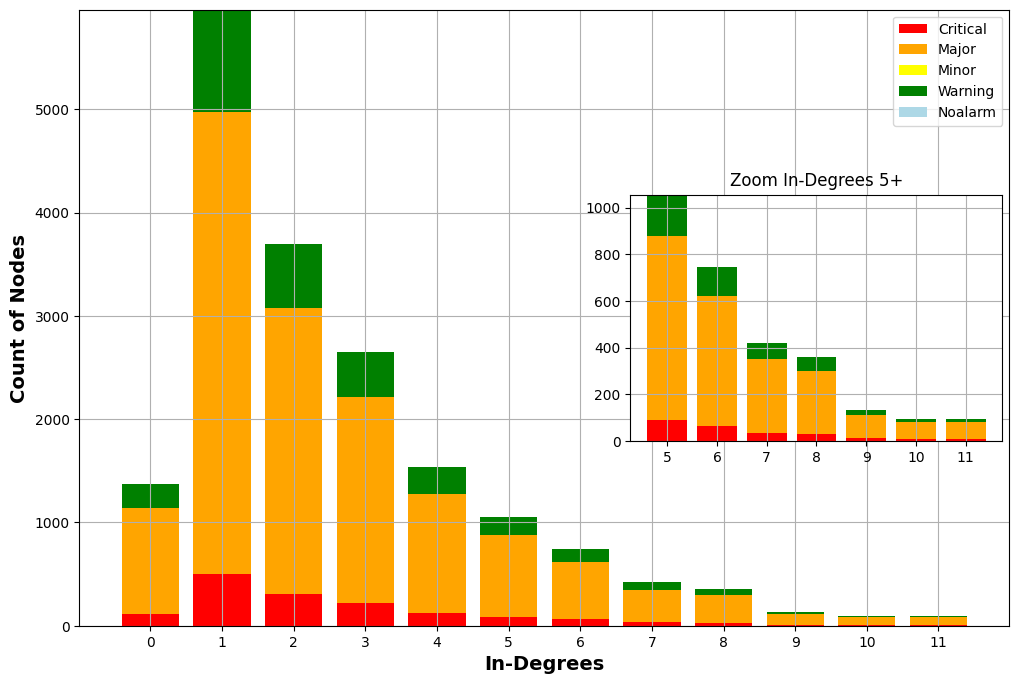

In [7]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Initialize a dictionary to store in-degree counts by severity
severity_indegree_counts = {severity: {} for severity in severity_colors.keys()}

# Populate the dictionary
for bs, counts in bs_indegree_counts.items():
    for in_degree, count in counts.items():
        # Identify the severity of each node
        for node in G_filtered.nodes():
            node_severity = number_to_severity.get(node, 'Noalarm')

            if in_degree not in severity_indegree_counts[node_severity]:
                severity_indegree_counts[node_severity][in_degree] = 0
            severity_indegree_counts[node_severity][in_degree] += count

# Data preparation for plotting
in_degrees = set()
for severity in severity_indegree_counts:
    in_degrees = in_degrees.union(set(severity_indegree_counts[severity].keys()))
in_degrees = sorted(list(in_degrees))

# Plotting
fig, ax = plt.subplots(figsize=(12, 8))

# Stack bars for each severity level
bottoms = [0] * len(in_degrees)
for severity, color in severity_colors.items():
    counts = [severity_indegree_counts[severity].get(in_degree, 0) for in_degree in in_degrees]
    ax.bar(in_degrees, counts, bottom=bottoms, color=color, label=severity)
    bottoms = [bottoms[i] + counts[i] for i in range(len(counts))]

ax.set_xlabel('In-Degrees', fontsize=14, fontweight='bold')
ax.set_ylabel('Count of Nodes', fontsize=14, fontweight='bold')
# ax.set_title('Stacked In-Degrees by Criticality of Alarms')
ax.set_xticks(in_degrees)

# Create inset plot
inset_ax = inset_axes(ax, width="40%", height="40%", loc='right')
inset_bottoms = [0] * len([d for d in in_degrees if d >= 5])
for severity, color in severity_colors.items():
    inset_counts = [severity_indegree_counts[severity].get(in_degree, 0) for in_degree in in_degrees if in_degree >= 5]
    inset_ax.bar([d for d in in_degrees if d >= 5], inset_counts, bottom=inset_bottoms, color=color)
    inset_bottoms = [inset_bottoms[i] + inset_counts[i] for i in range(len(inset_counts))]

inset_ax.set_xticks([d for d in in_degrees if d >= 5])
inset_ax.set_title('Zoom In-Degrees 5+')

ax.legend(loc='upper right')
# inset_ax.legend(loc='upper right')

ax.grid()
inset_ax.grid()
plt.show()

# **Plot of indegree:outdegree**

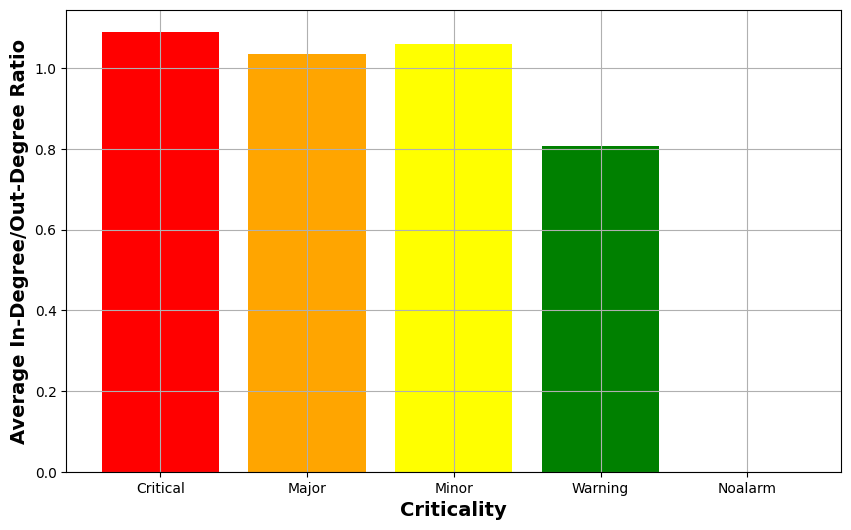

In [8]:
bs=df.loc[:,'Alarm Source'].unique()
# Initialize a dictionary to store in-degree/out-degree ratio sums and counts for each severity
severity_ratio_sums = {severity: 0 for severity in severity_colors.keys()}
severity_counts = {severity: 0 for severity in severity_colors.keys()}

for i in range(0, 100):
    G_filtered = nx.DiGraph()
    filtered_df = selected_df[selected_df['Alarm Source'] == bs[i]]

    for _, row in filtered_df.iterrows():
        if row['Next_Alarm_Number'] != 999:
            G_filtered.add_edge(row['Alarm_Number'], row['Next_Alarm_Number'])

    # Calculate in-degree/out-degree ratio and categorize by criticality
    for node in G_filtered.nodes():
        in_degree = G_filtered.in_degree(node)
        out_degree = G_filtered.out_degree(node)
        severity = number_to_severity.get(node, 'Noalarm')

        # Avoid division by zero and only consider nodes with non-zero out-degree
        if out_degree > 0:
            ratio = in_degree / out_degree
            severity_ratio_sums[severity] += ratio
            severity_counts[severity] += 1

# Calculate average ratios for each severity
average_ratios = {severity: (severity_ratio_sums[severity] / severity_counts[severity]) if severity_counts[severity] > 0 else 0 for severity in severity_colors.keys()}

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(average_ratios.keys(), average_ratios.values(), color=list(severity_colors.values()))
plt.xlabel('Criticality', fontsize=14, fontweight='bold')
plt.ylabel('Average In-Degree/Out-Degree Ratio', fontsize=14, fontweight='bold')
# plt.title('Average In-Degree/Out-Degree Ratio by Criticality')
plt.grid()
plt.show()

# Graphing selective degrees for BS Specific alarm relationships and color coded severity of **alarms**

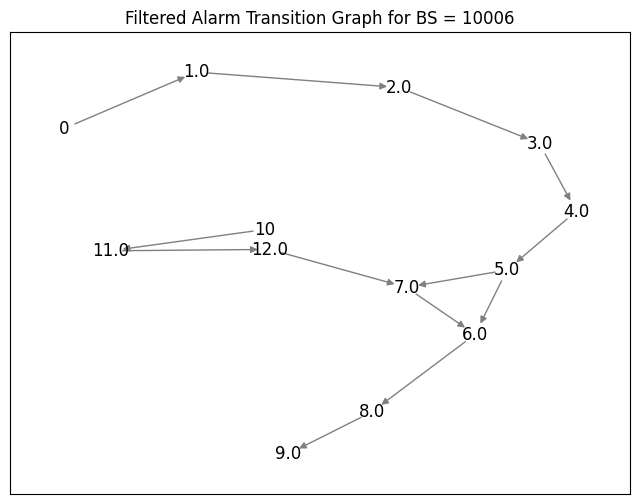

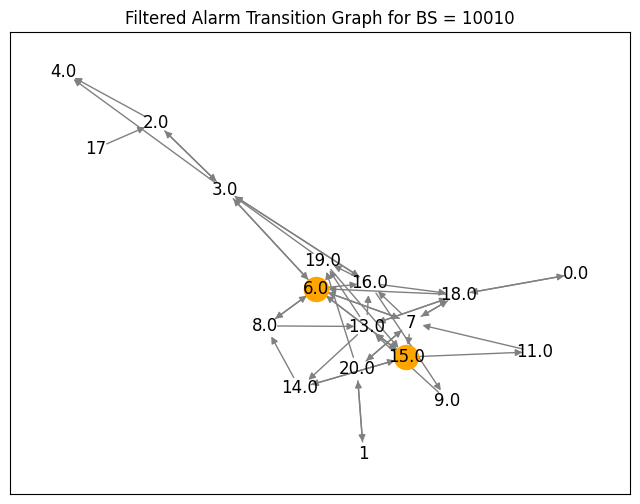

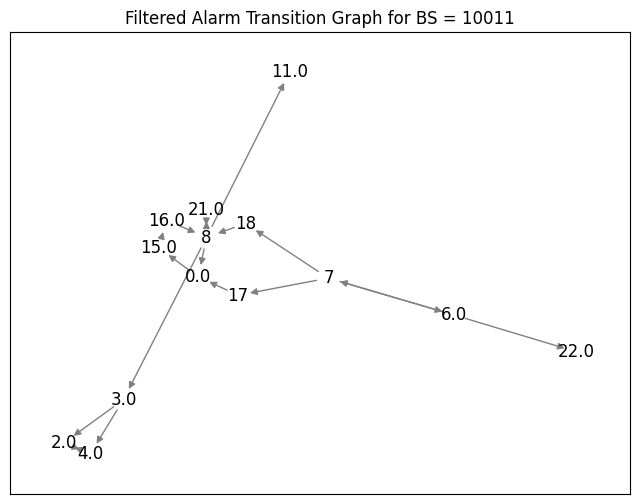

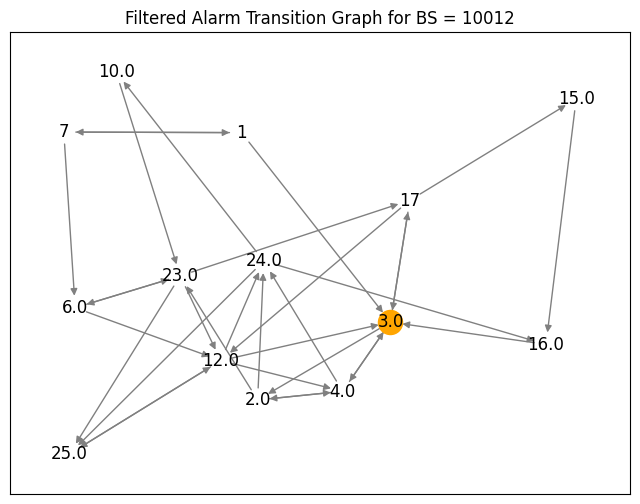

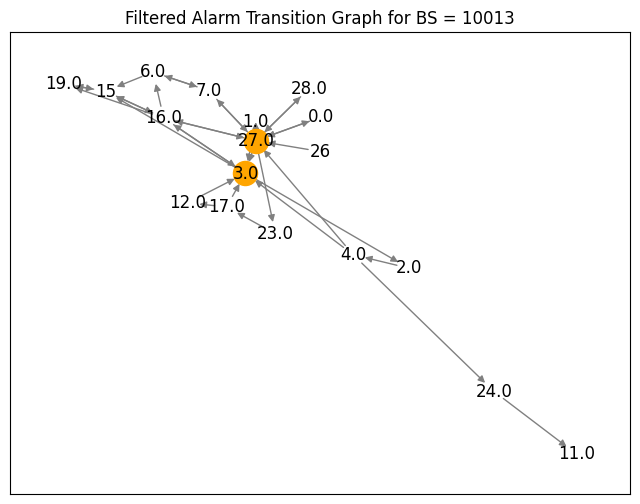

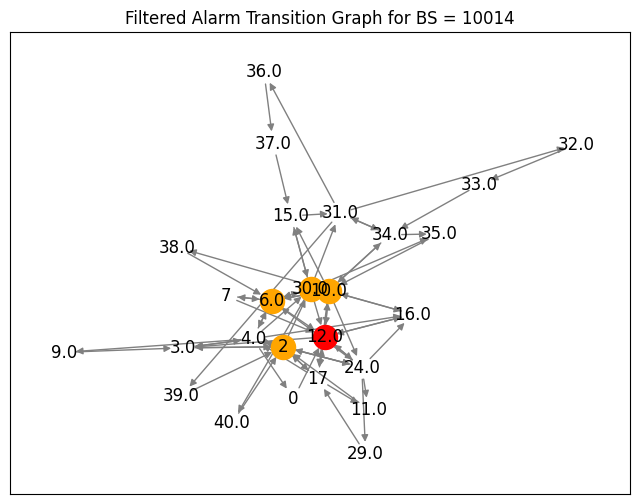

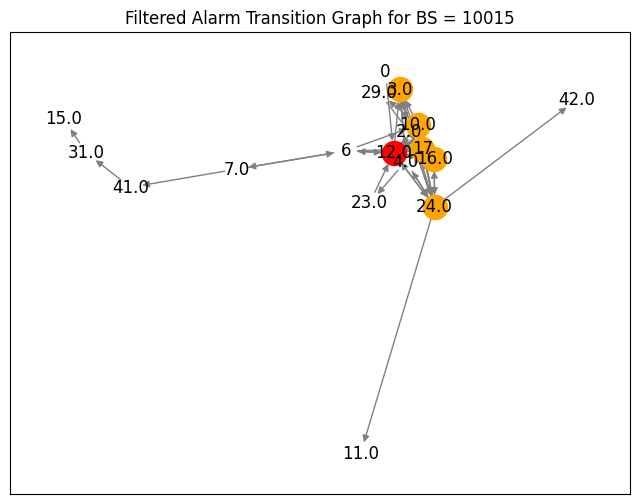

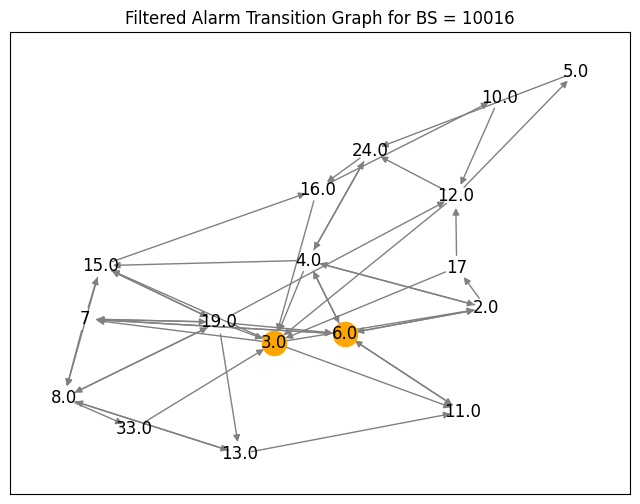

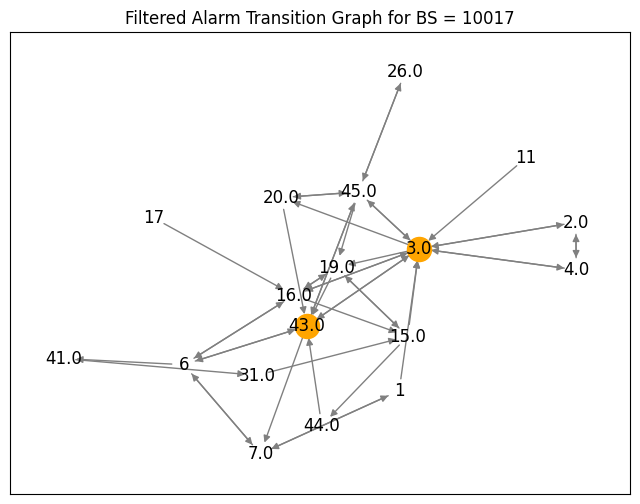

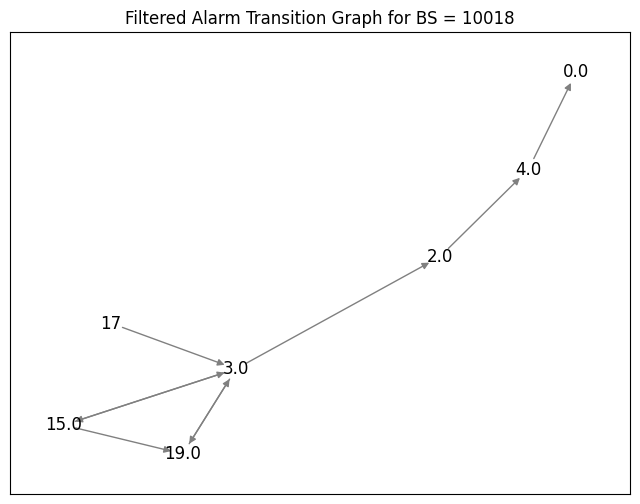

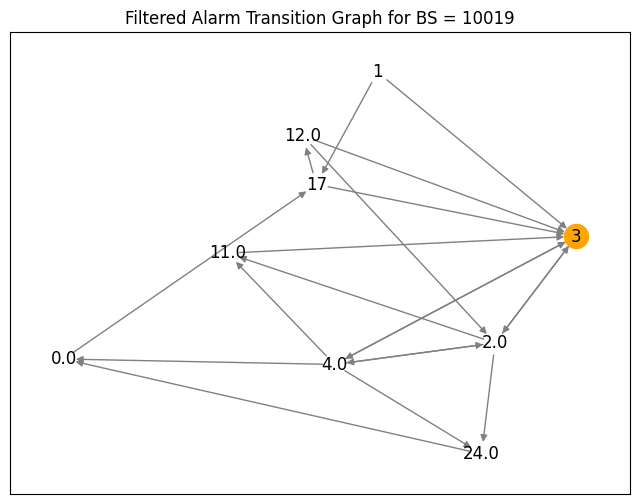

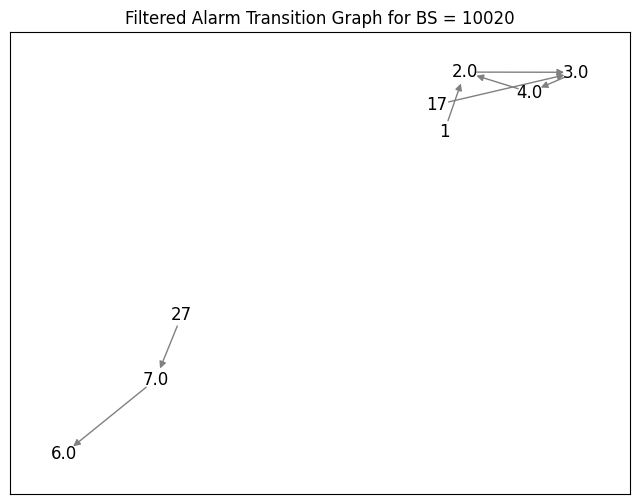

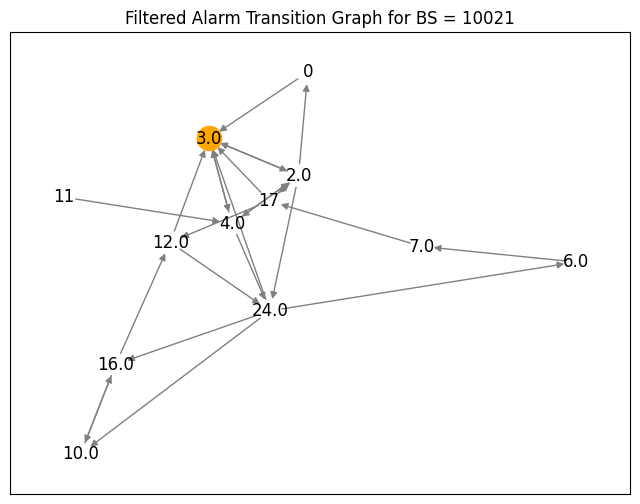

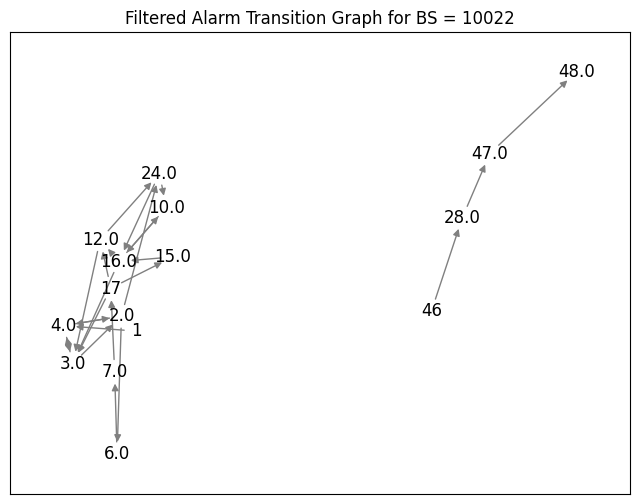

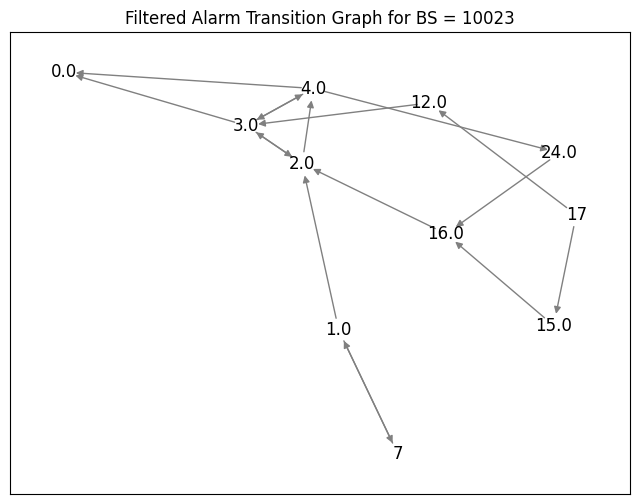

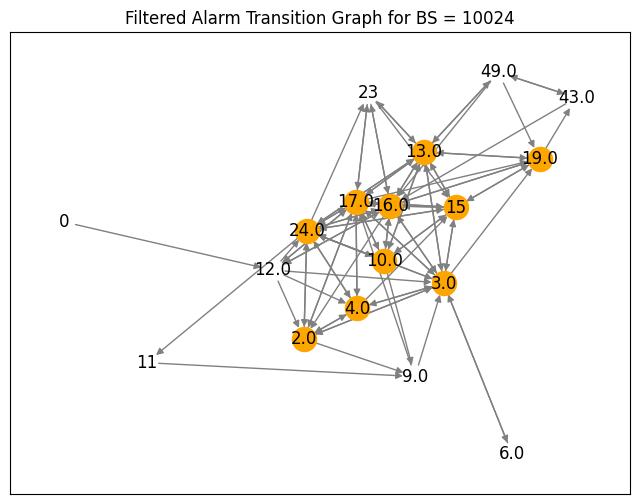

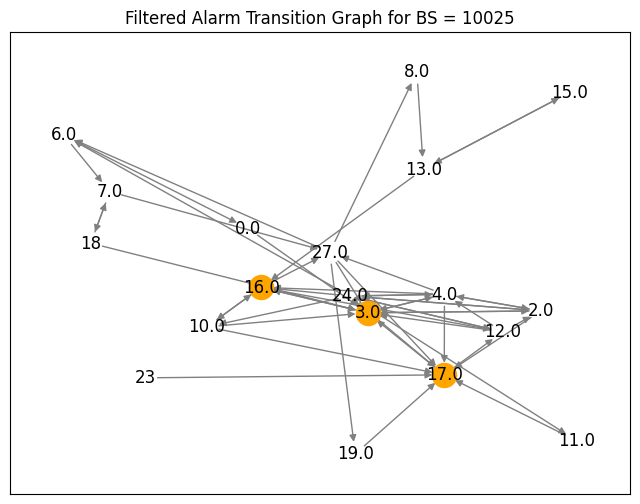

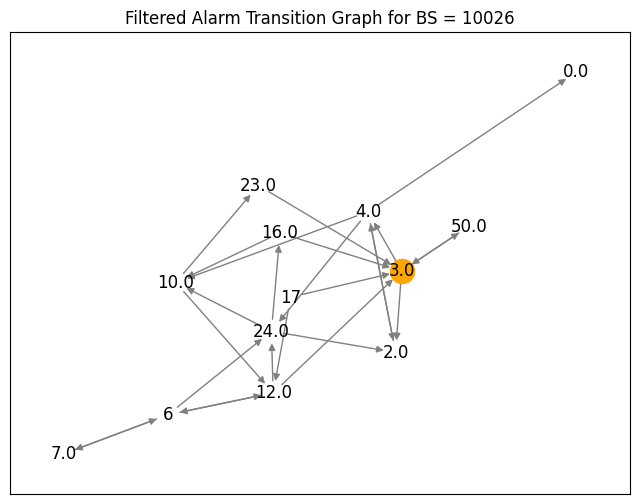

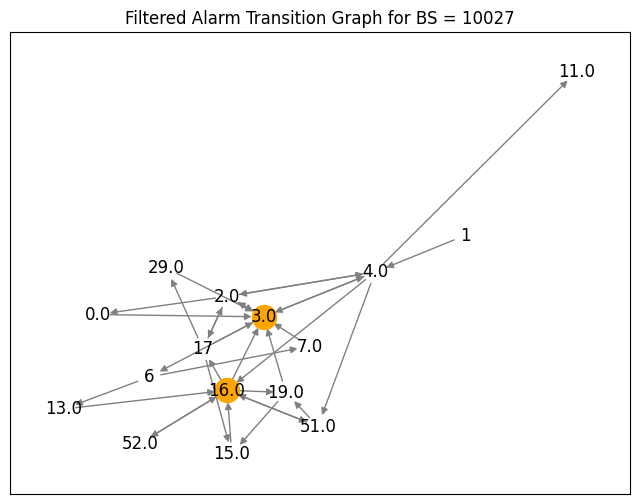

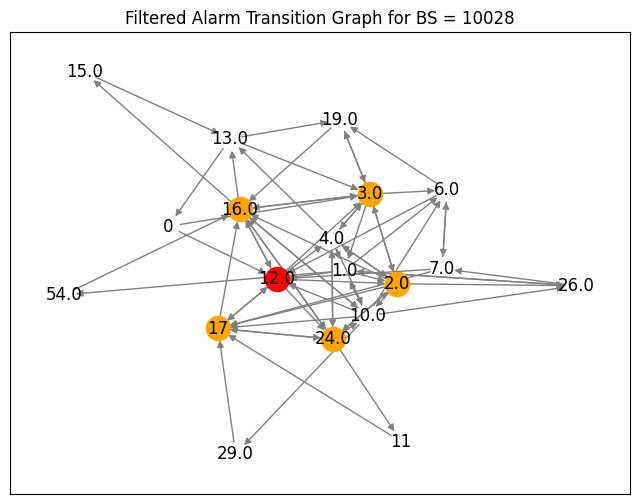

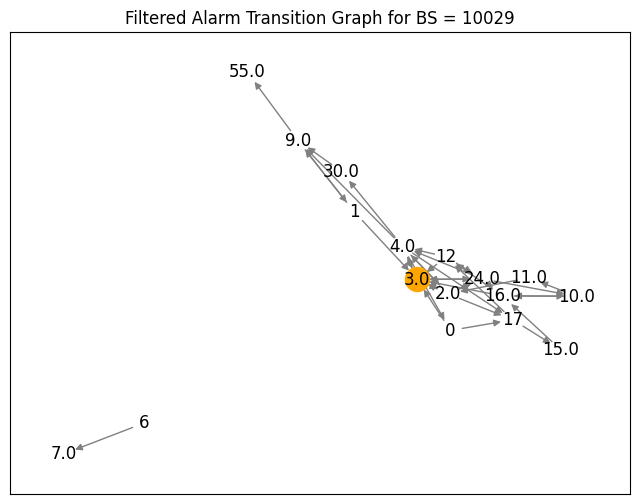

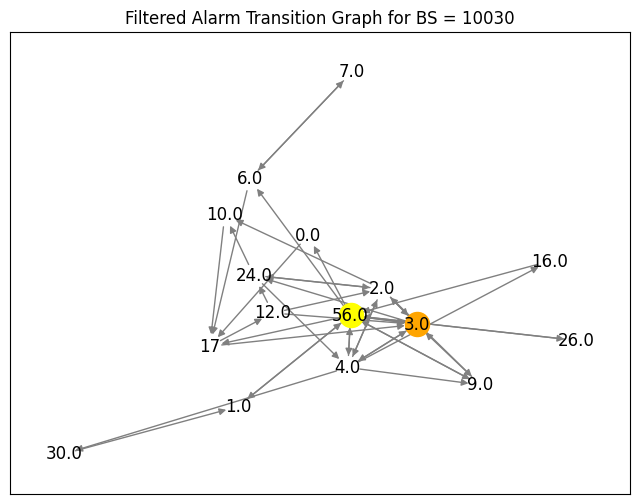

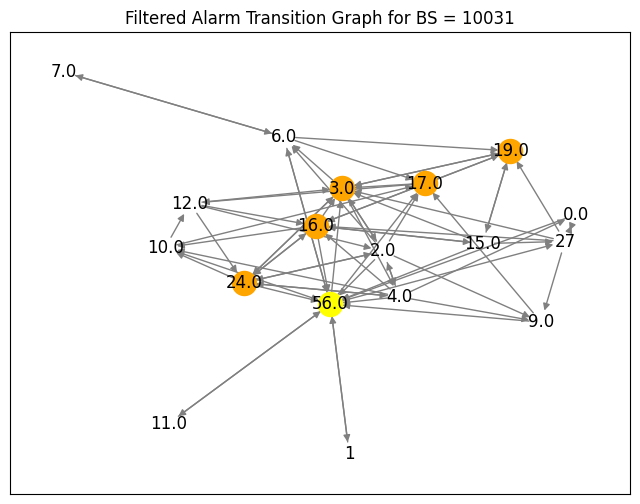

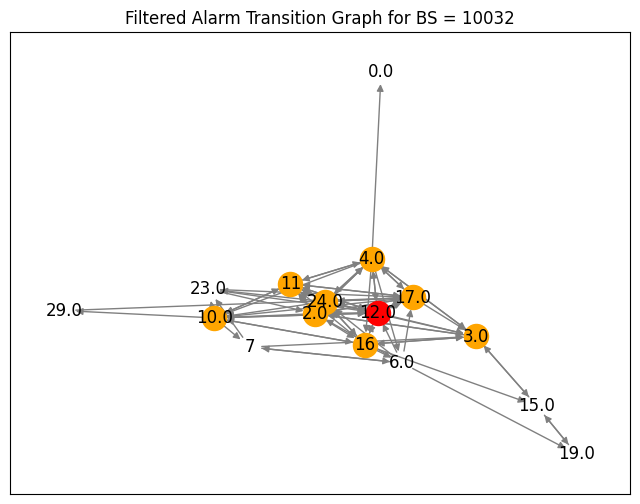

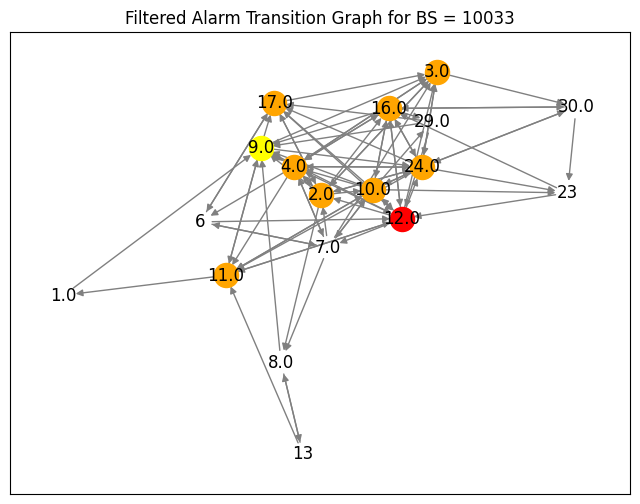

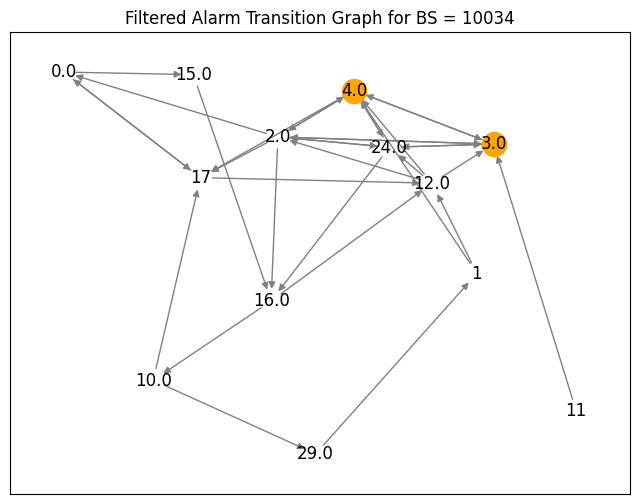

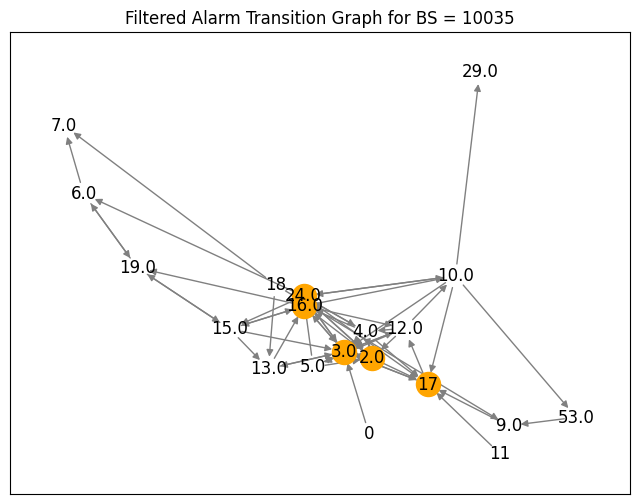

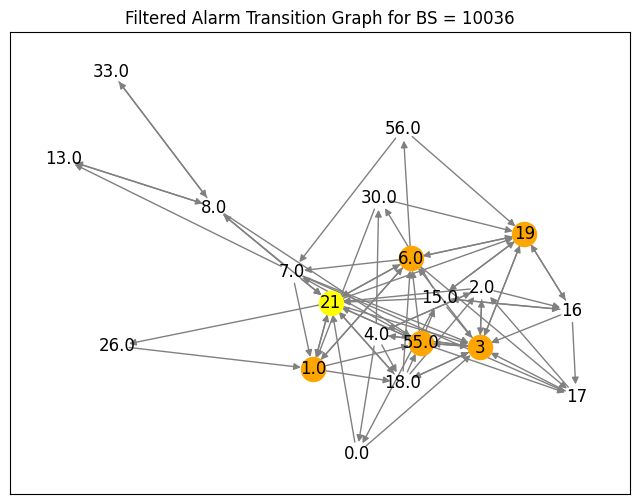

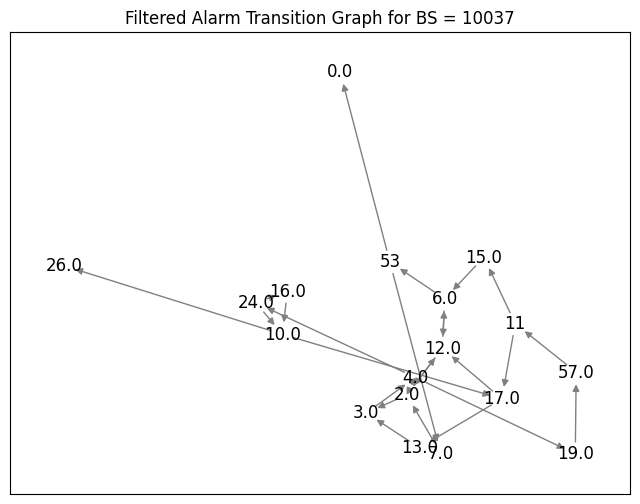

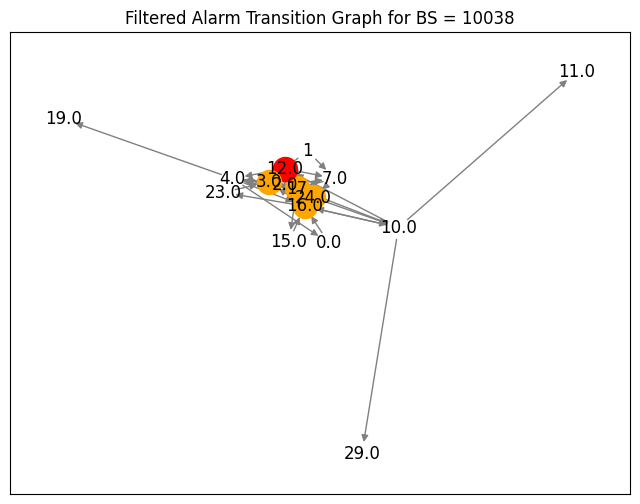

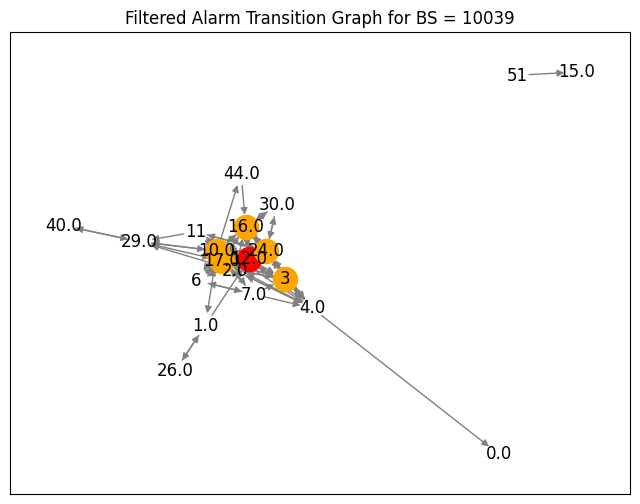

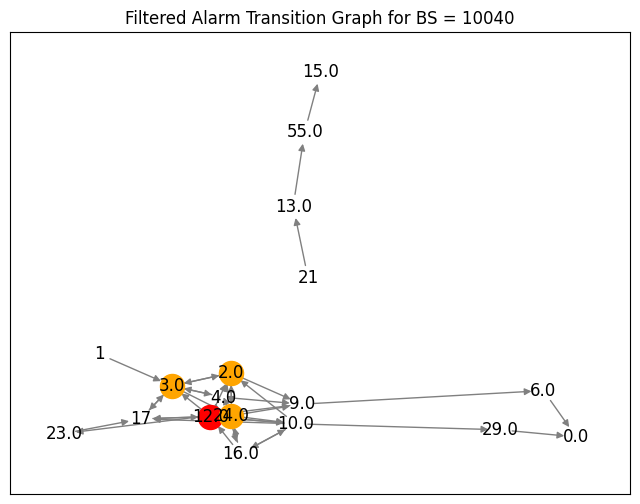

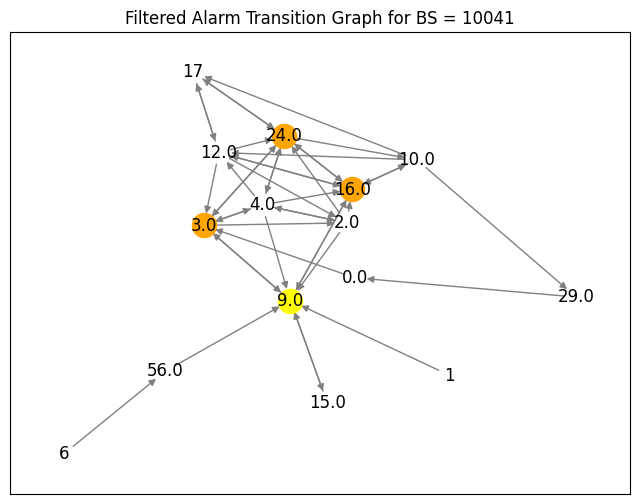

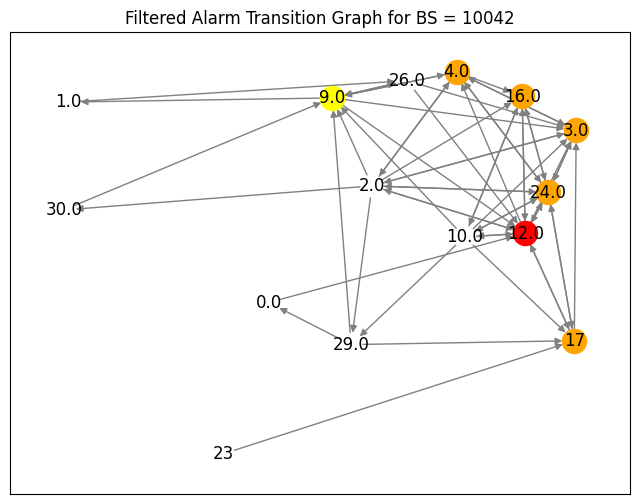

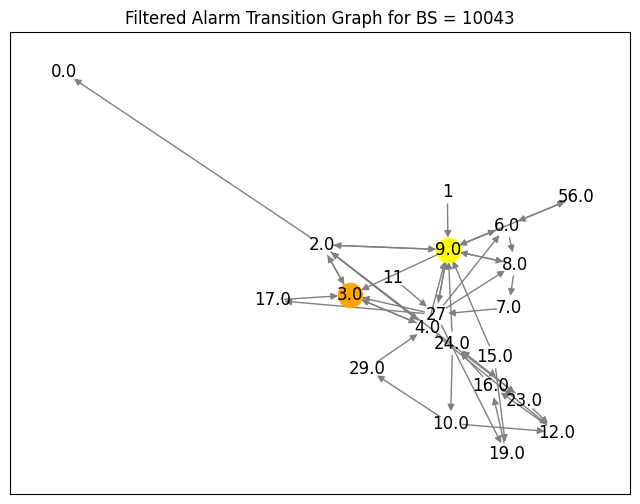

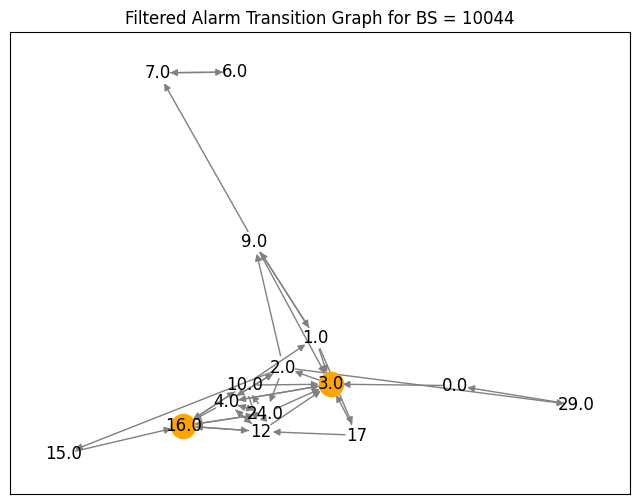

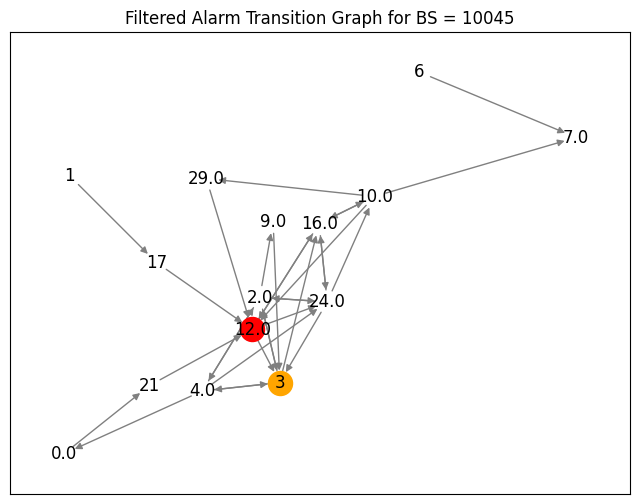

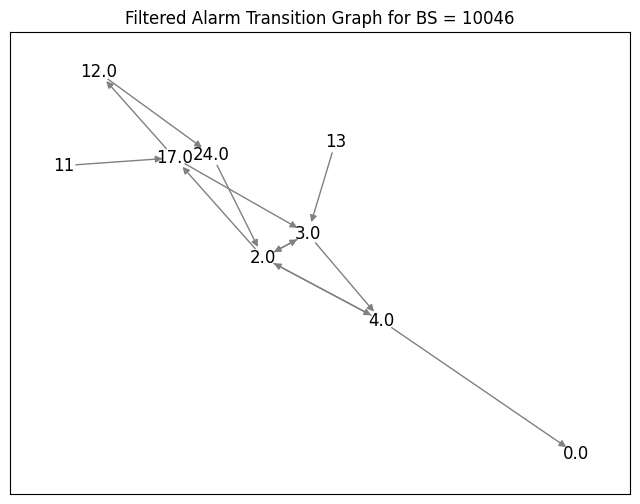

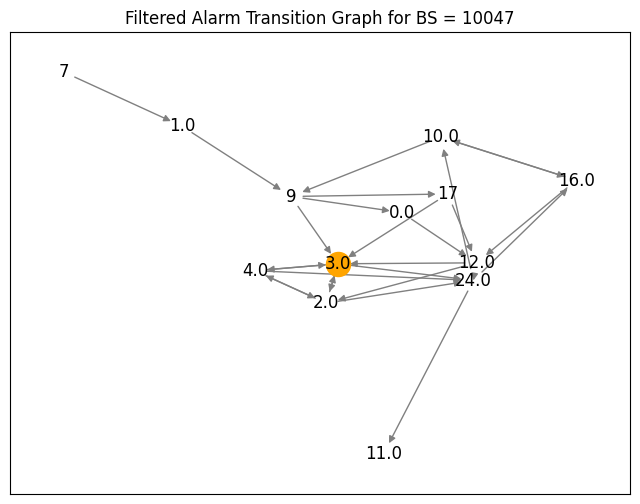

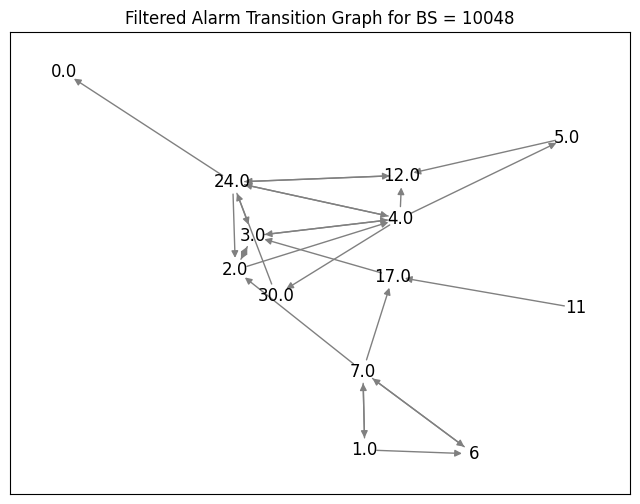

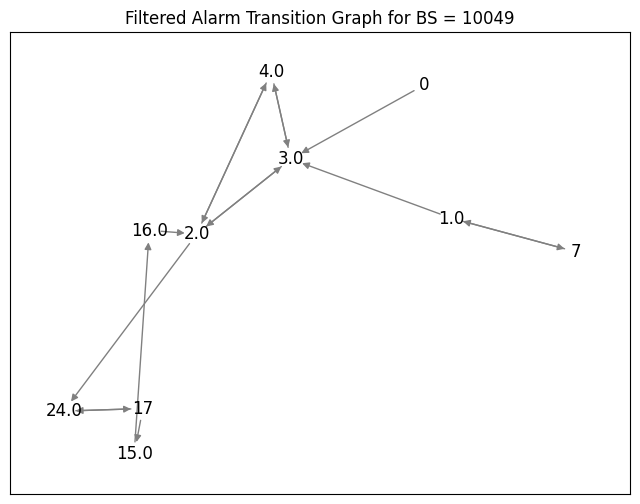

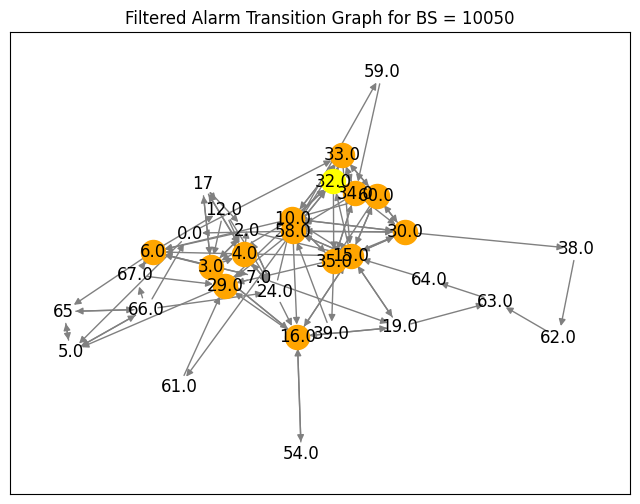

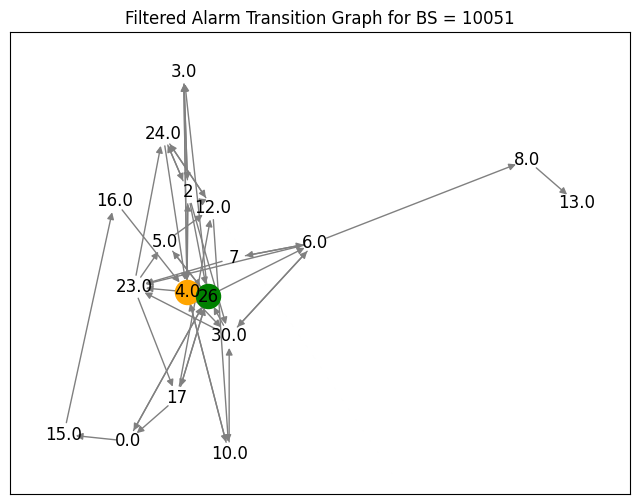

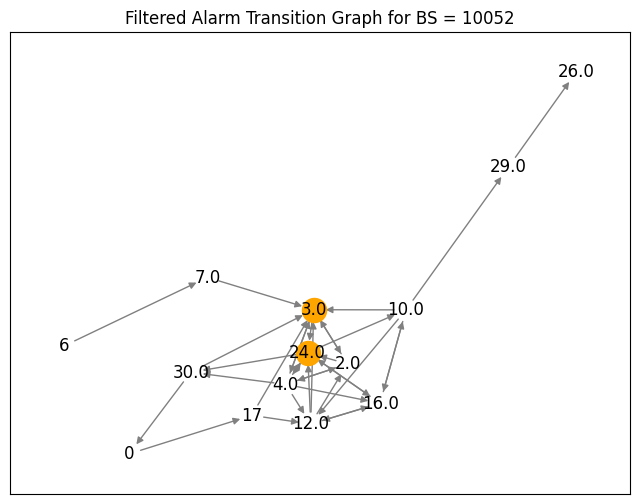

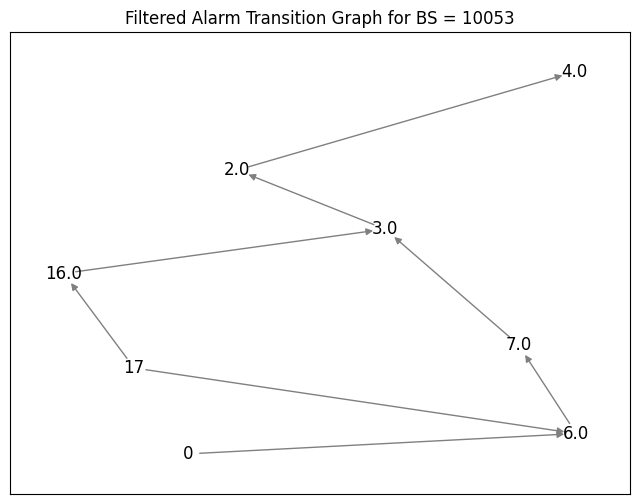

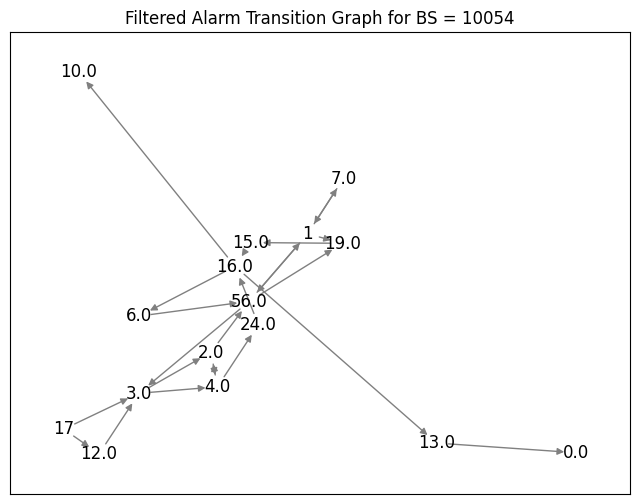

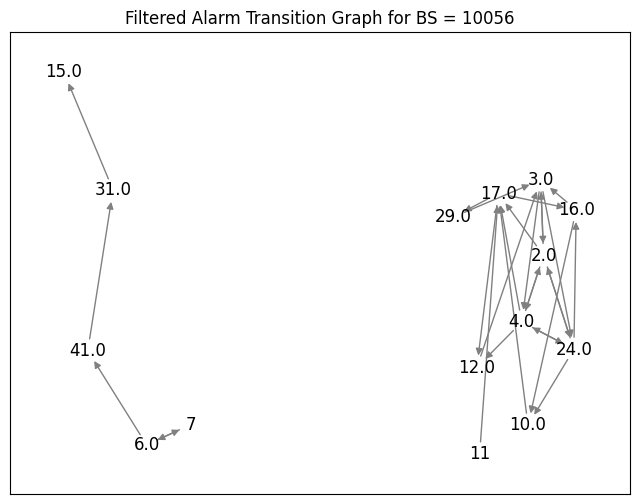

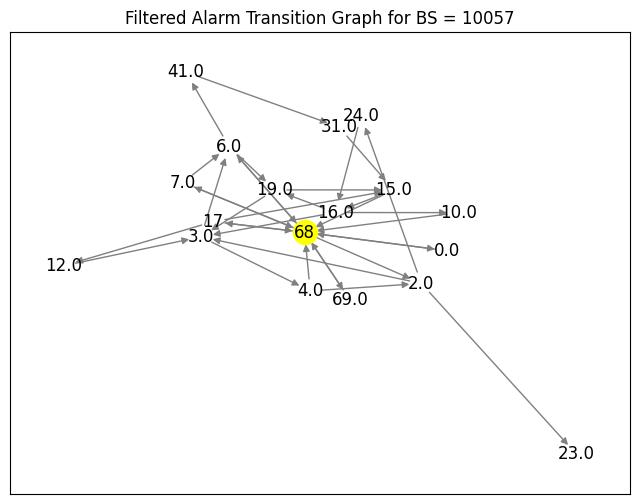

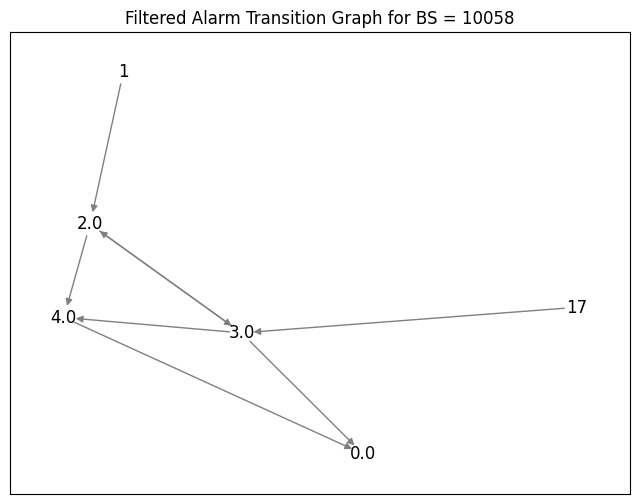

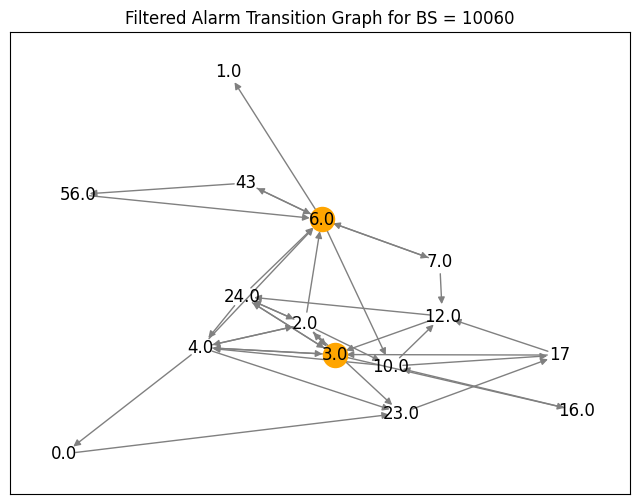

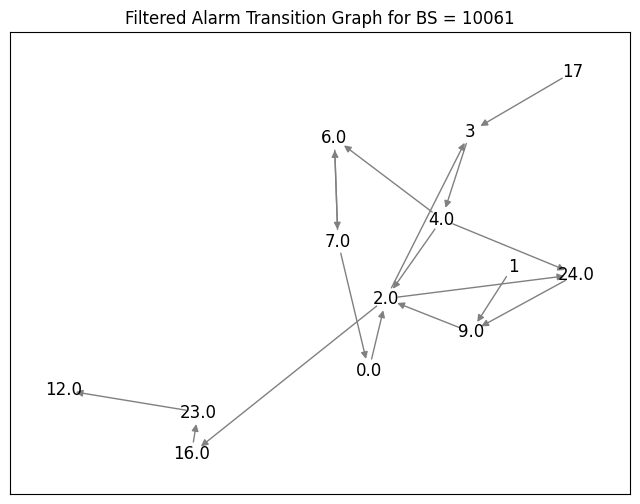

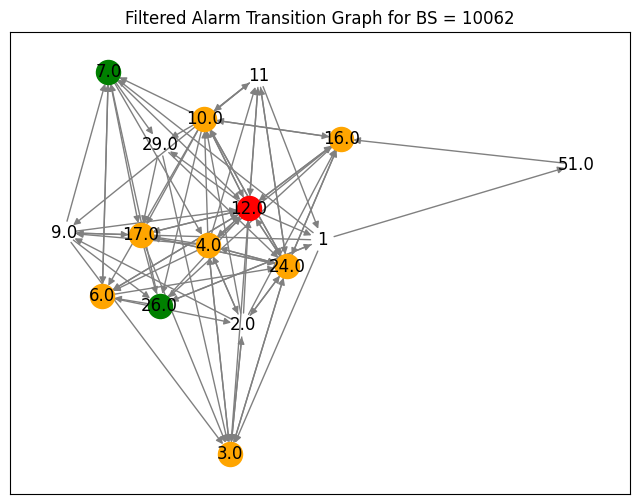

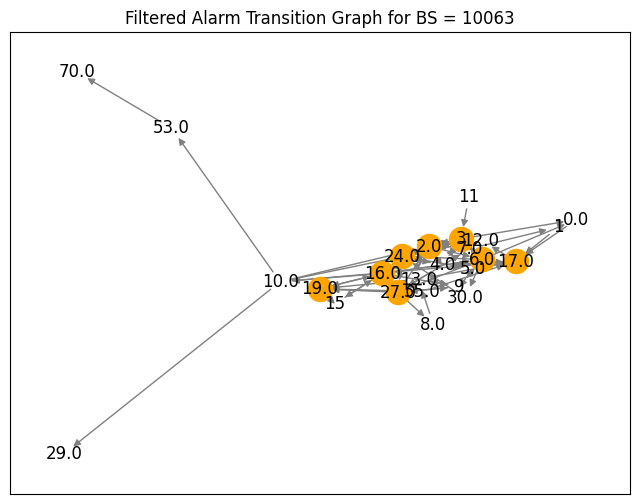

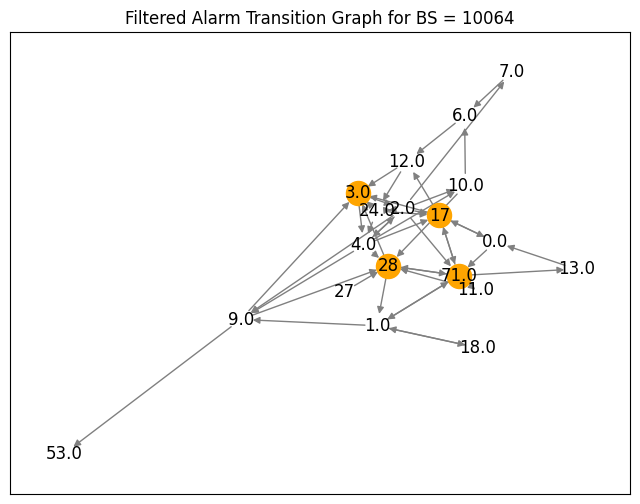

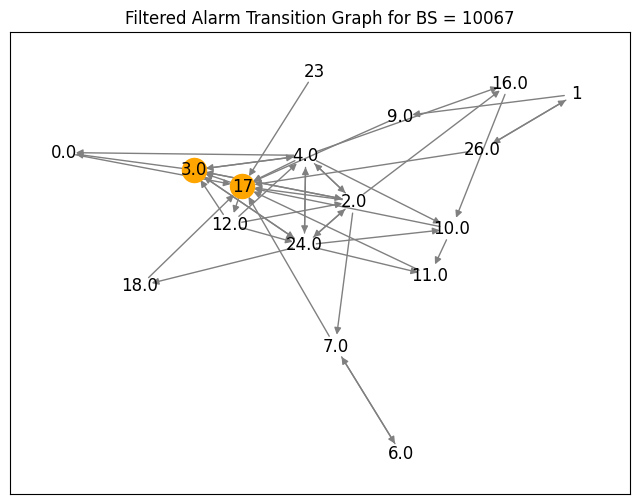

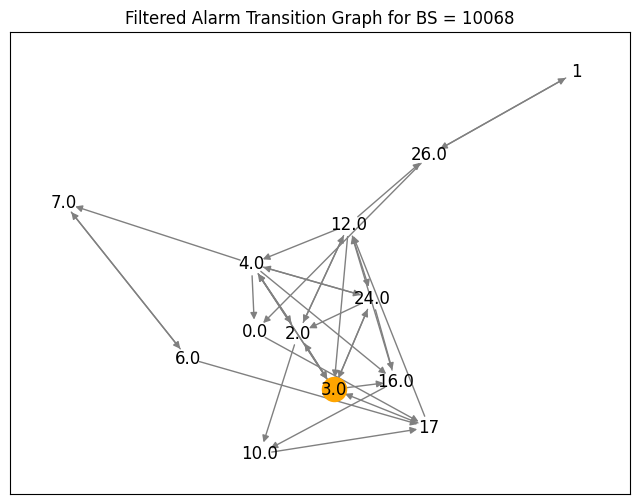

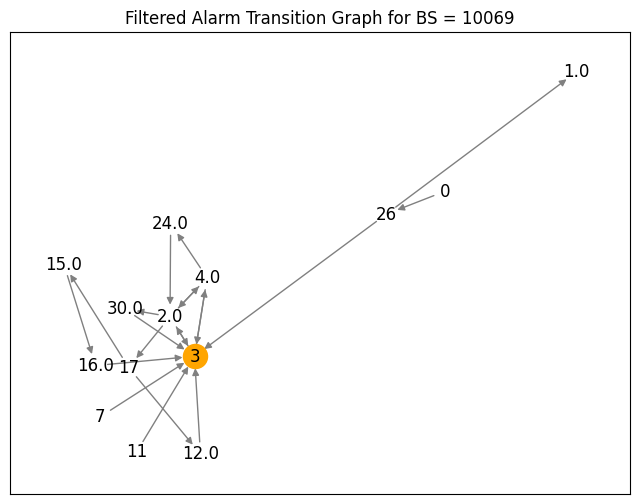

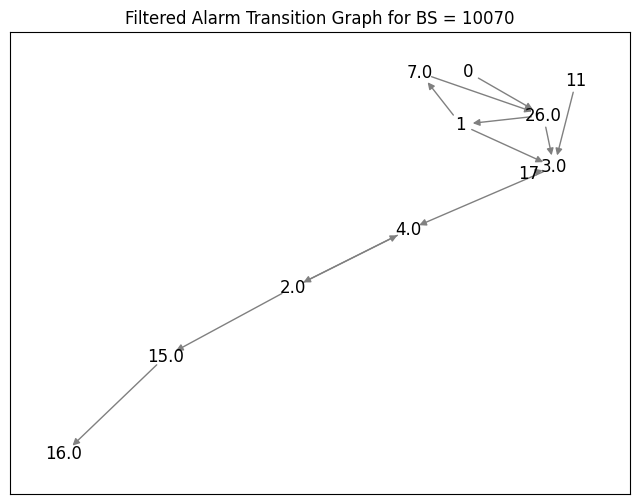

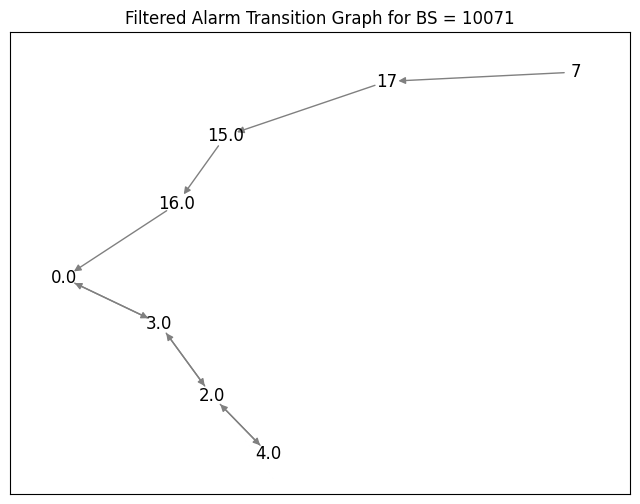

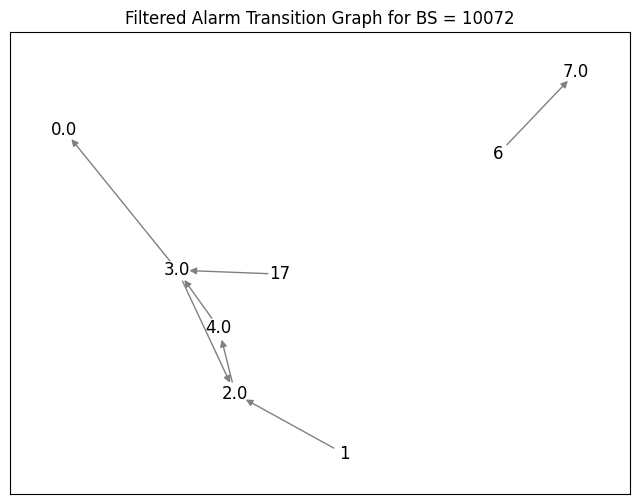

In [9]:
bs=df.loc[:,'Alarm Source'].unique()

# Use factorize to assign numbers to unique alarm names
labels, unique_values = pd.factorize(df['Name'])

# Map each alarm in the DataFrame to its assigned number
mapped_labels = labels[df['Name'].index]

# Create a DataFrame from the unique alarm names and their corresponding labels
alarm_name_number_df = pd.DataFrame({
    'Alarm_Name': df['Name'],
    'Alarm_Number': mapped_labels,
    'Severity': df['Severity']
})

# Dropping duplicates to have a unique mapping
alarm_name_number_df = alarm_name_number_df.drop_duplicates(subset=['Alarm_Name']).reset_index(drop=True)

os.makedirs('saved_graphs', exist_ok=True)

graph_data=[]

# Mapping of alarm numbers to their severities
number_to_severity = pd.Series(alarm_name_number_df['Severity'].values, index=alarm_name_number_df['Alarm_Number']).to_dict()

# Color mapping based on severity
severity_colors = {'Critical': 'red', 'Major': 'orange', 'Minor': 'yellow', 'Warning': 'green', 'Noalarm': 'lightblue'}

for i in range(0, 60):
    G_filtered = nx.DiGraph()
    filtered_df = selected_df[selected_df['Alarm Source'] == bs[i]]

    for _, row in filtered_df.iterrows():
        if row['Next_Alarm_Number'] != 999:
            G_filtered.add_edge(row['Alarm_Number'], row['Next_Alarm_Number'])

    # Save the graph to disk
    graph_filename = f'saved_graphs/graph_{i}.gml'
    nx.write_gml(G_filtered, graph_filename)

    graph_data.append(graph_filename)

    # Filter nodes with in-degree > 2
    nodes_to_plot = [node for node in G_filtered.nodes if G_filtered.in_degree(node) > 4]

    # Define node colors and shapes for filtered nodes
    node_colors = [severity_colors.get(number_to_severity.get(node, 'Noalarm'), 'lightblue') for node in nodes_to_plot]
    node_shapes = ['s' if G_filtered.out_degree(node) == 0 else 'o' for node in nodes_to_plot]

    # Visualize the graph with different node shapes for filtered nodes
    plt.figure(figsize=(8, 6))  # Adjust the size as needed
    pos = nx.spring_layout(G_filtered)  # Position layout for nodes

    for node, shape in zip(nodes_to_plot, node_shapes):
        nx.draw_networkx_nodes(G_filtered, pos=pos, nodelist=[node],
                               node_color=[node_colors[nodes_to_plot.index(node)]],
                               node_shape=shape)

    nx.draw_networkx_edges(G_filtered, pos=pos, edge_color='gray')
    nx.draw_networkx_labels(G_filtered, pos=pos, font_size=12)

    plt.title(f'Filtered Alarm Transition Graph for BS = {bs[i]}')
    plt.show()

# **Causality of BS-wise alarms with specific out degrees.**

In [ ]:
!pip install plotly

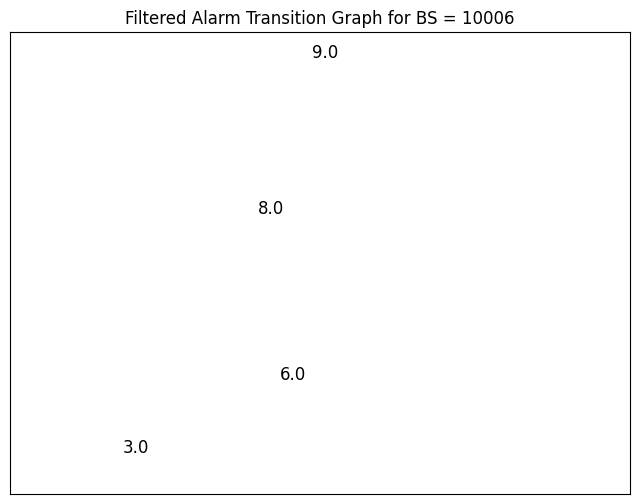

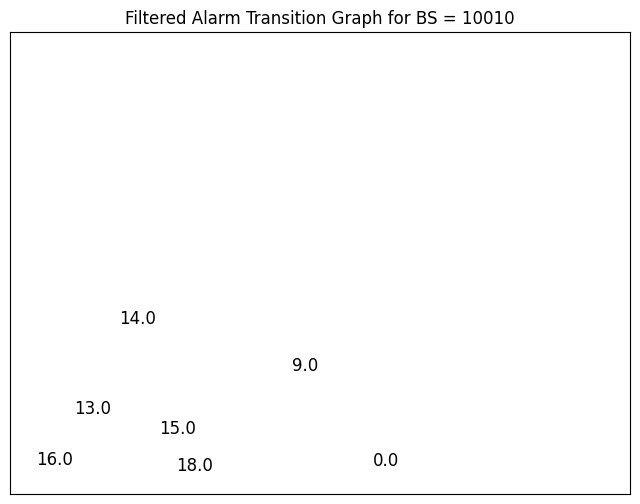

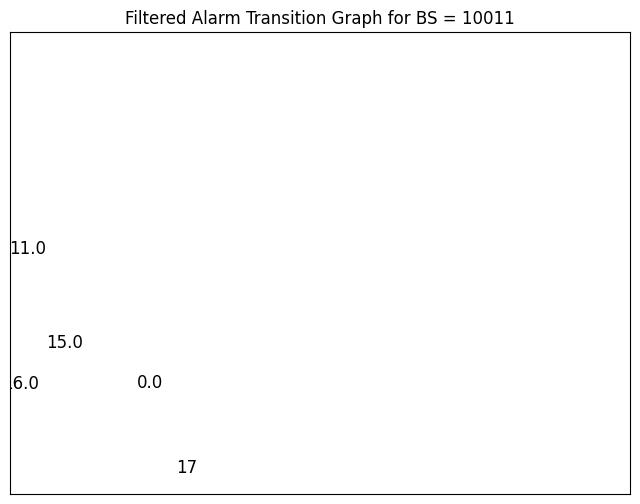

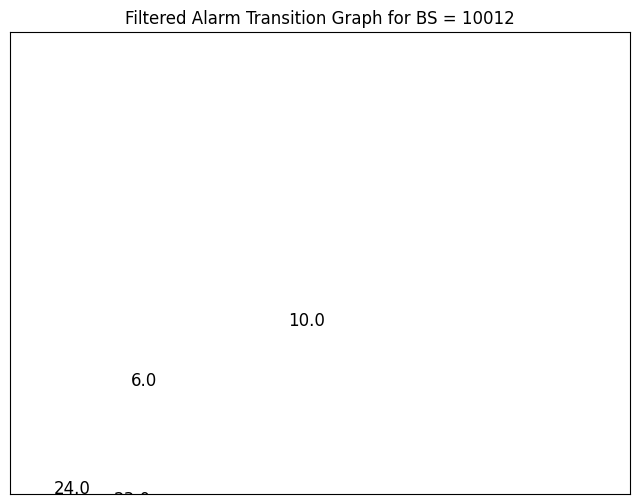

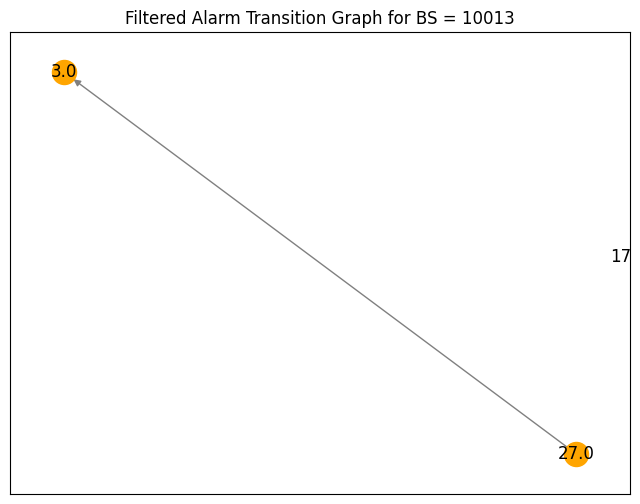

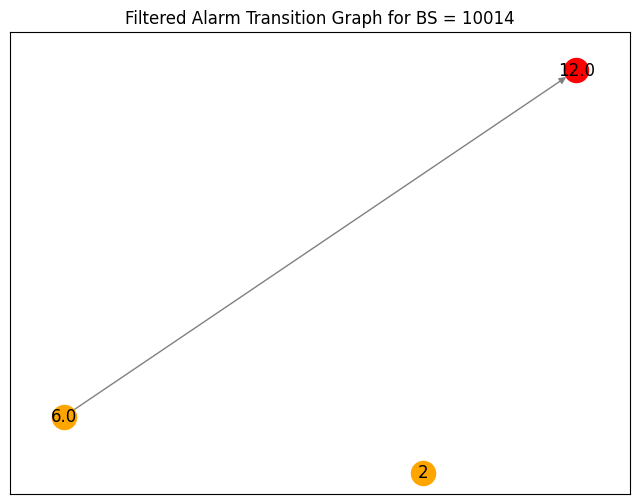

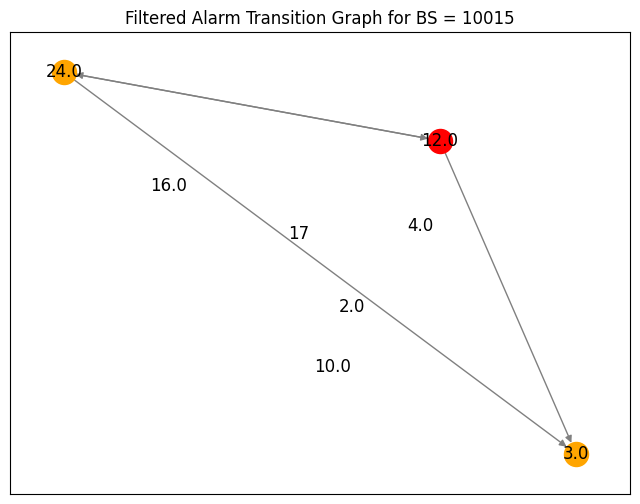

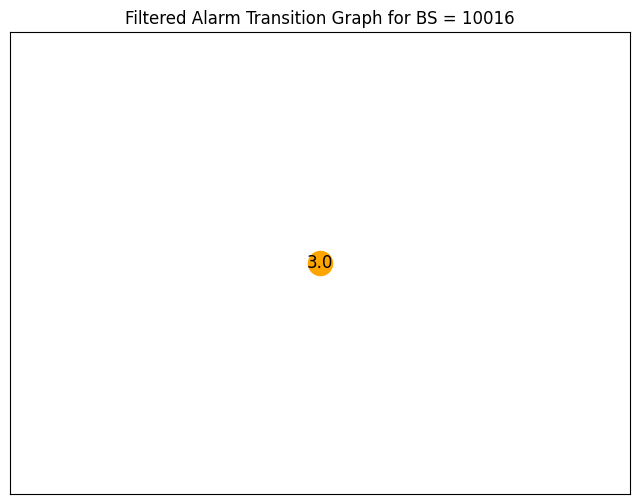

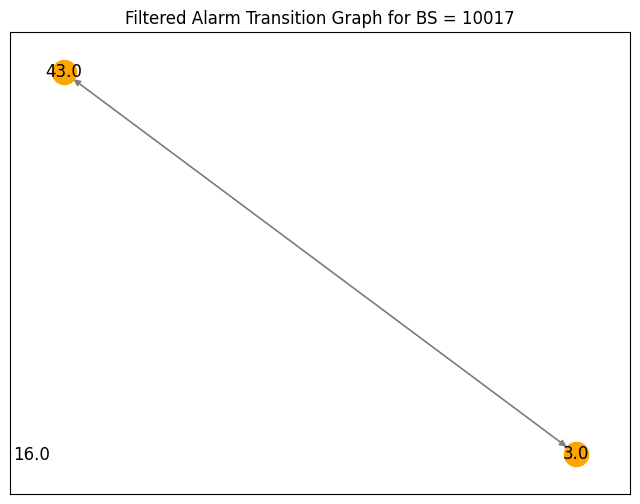

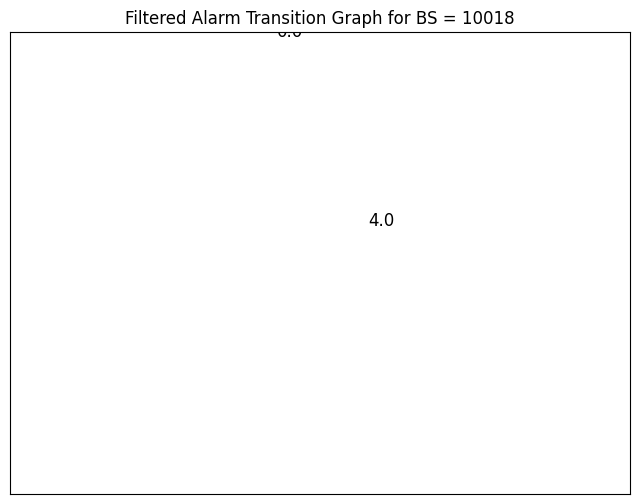

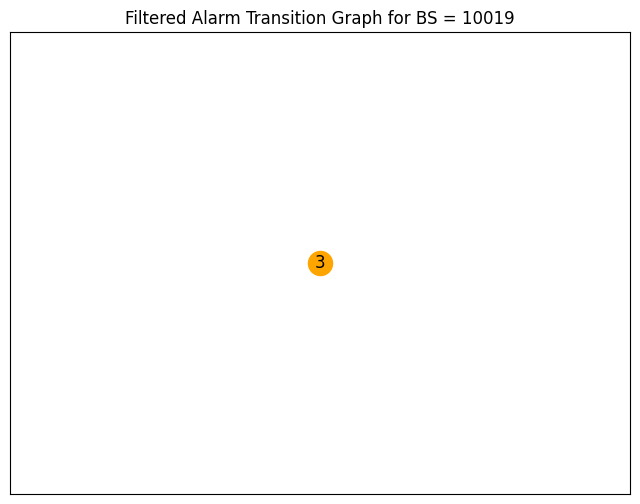

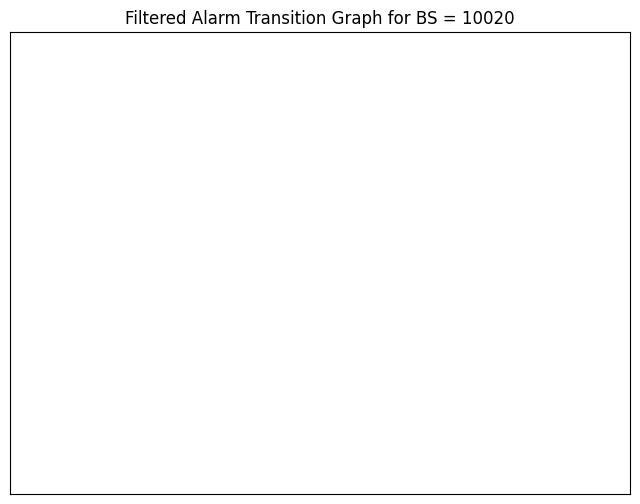

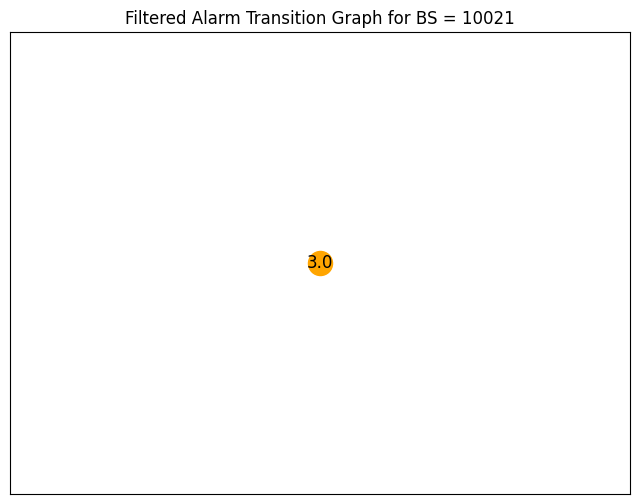

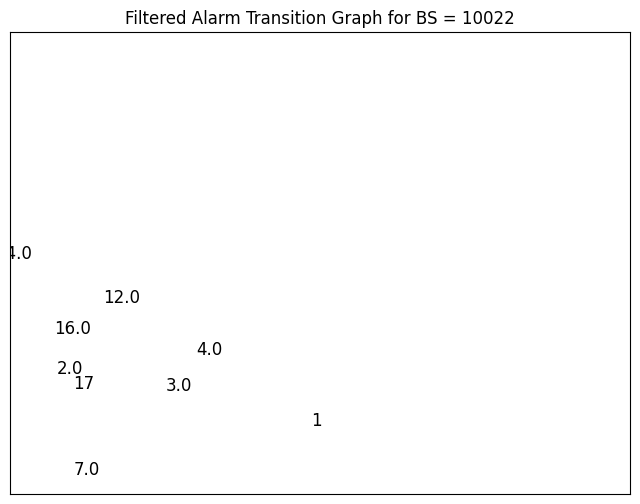

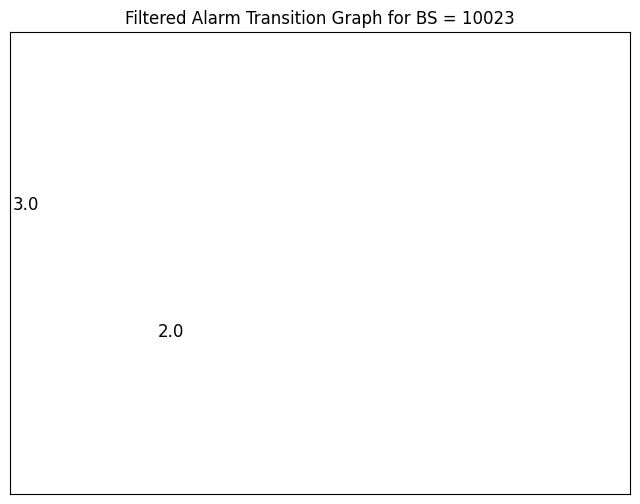

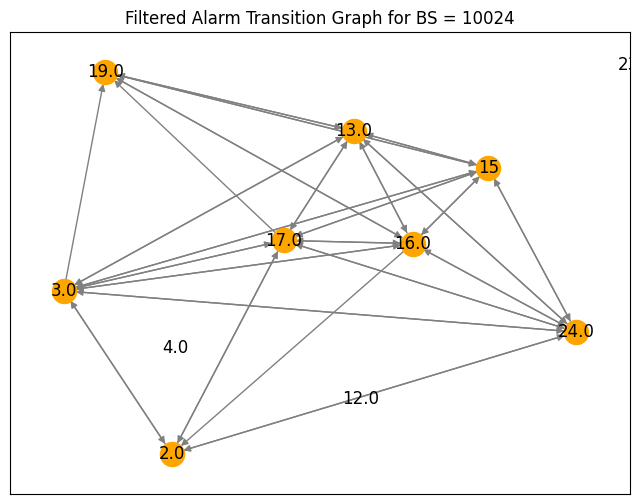

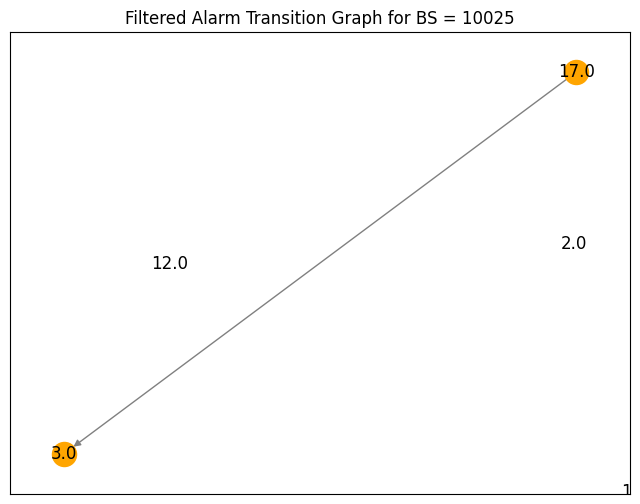

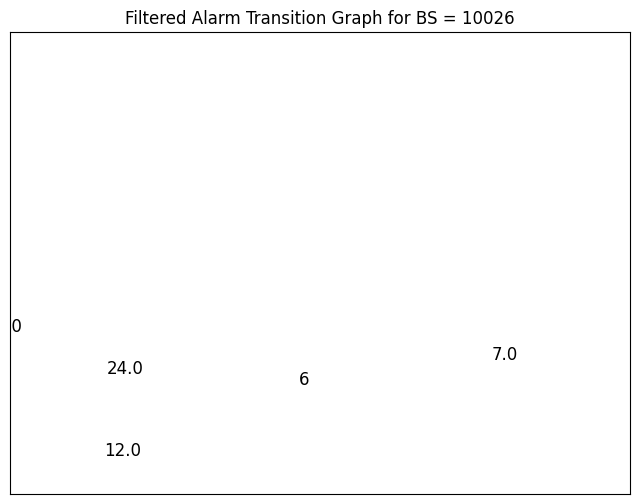

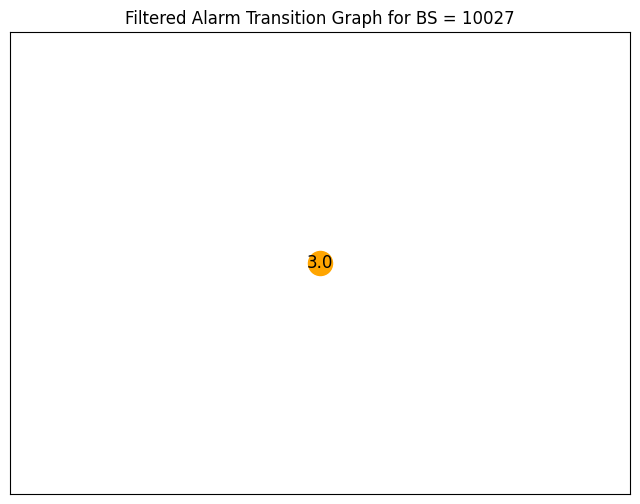

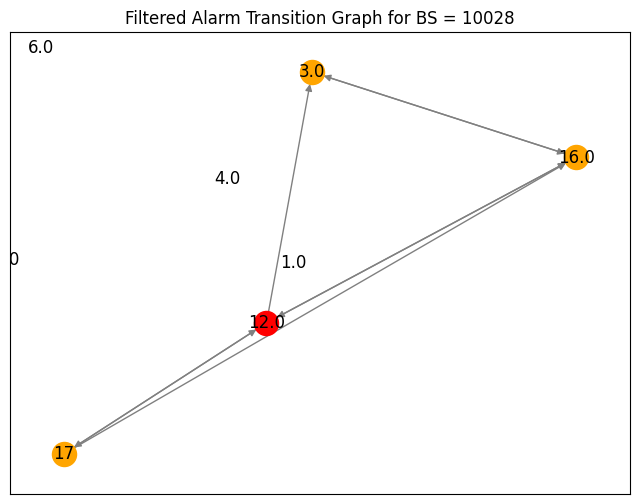

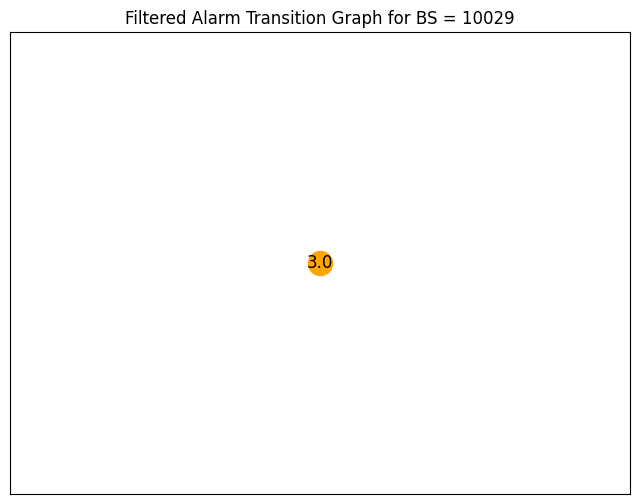

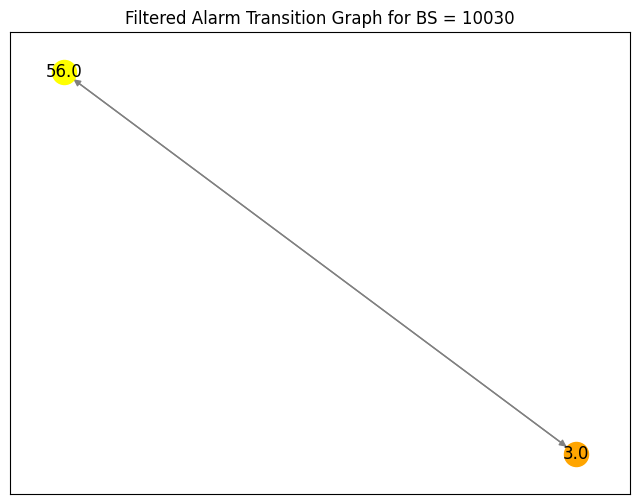

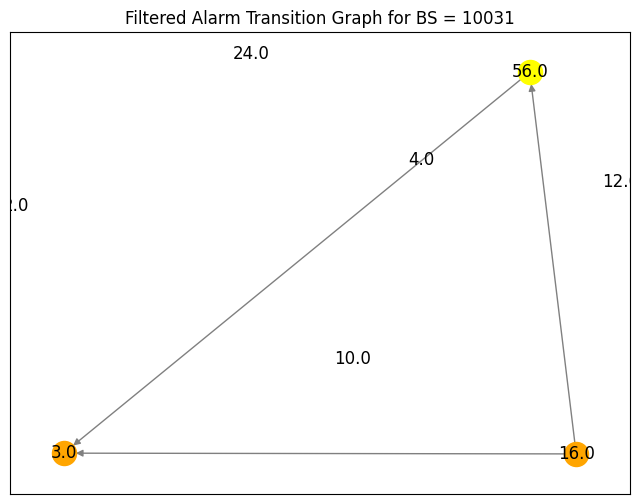

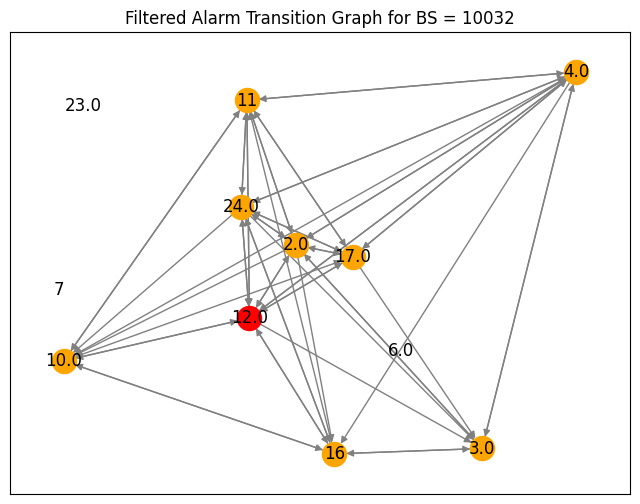

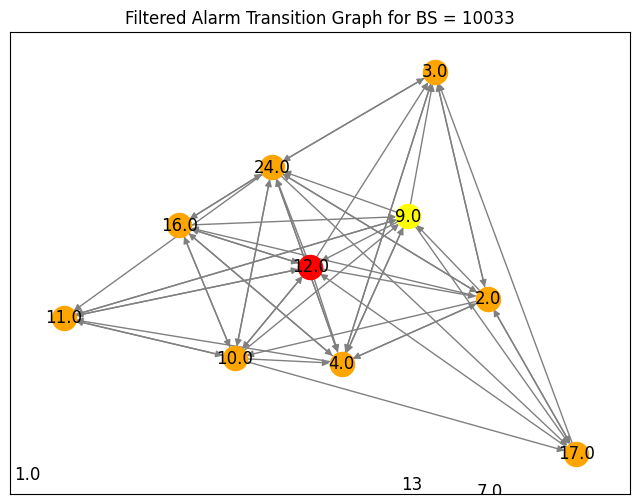

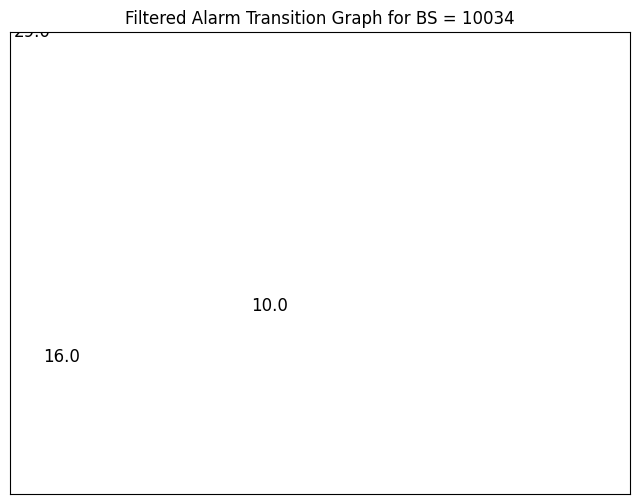

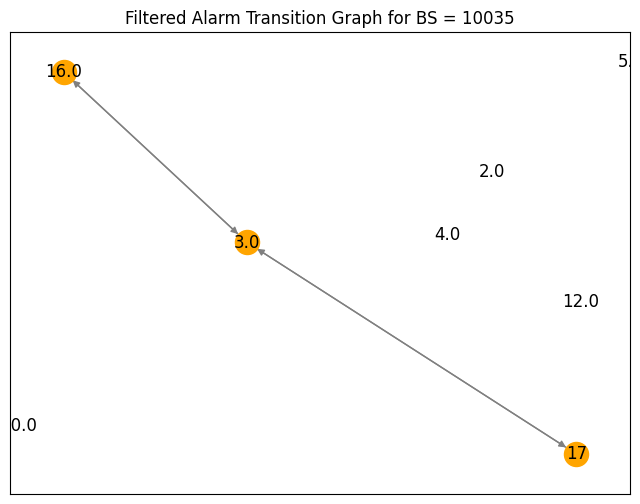

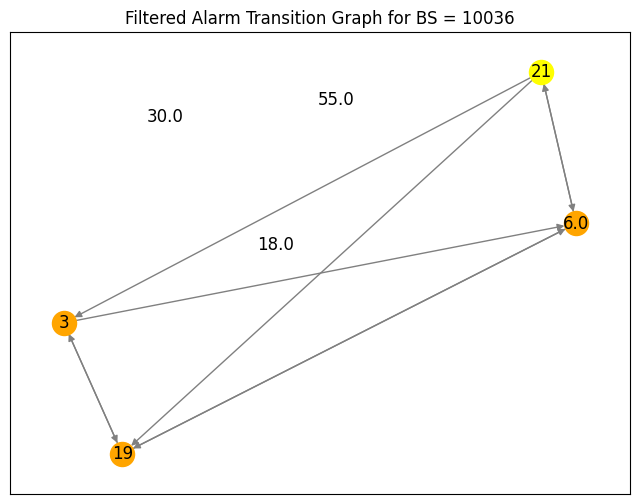

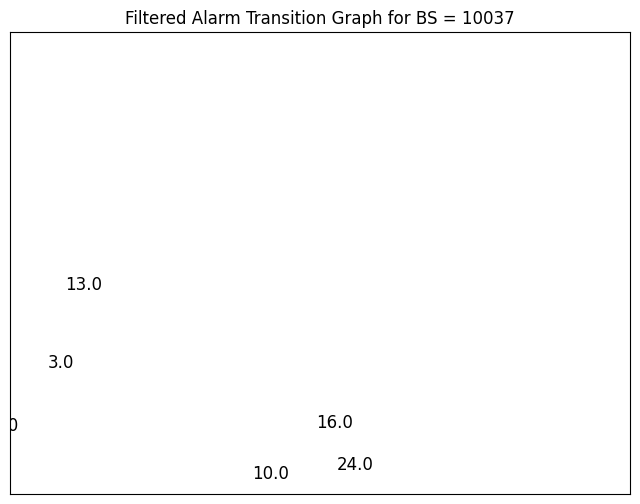

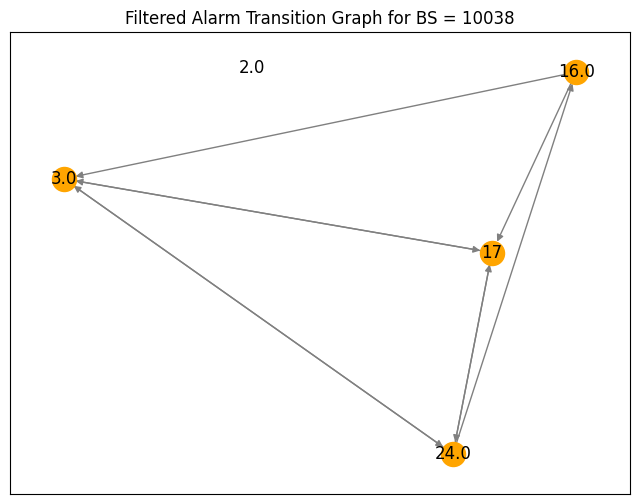

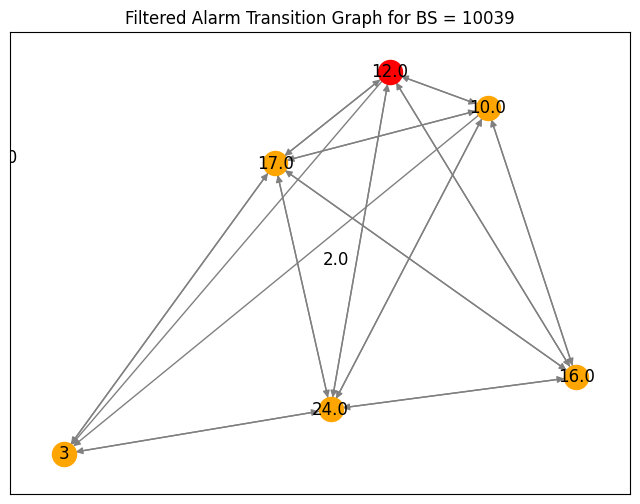

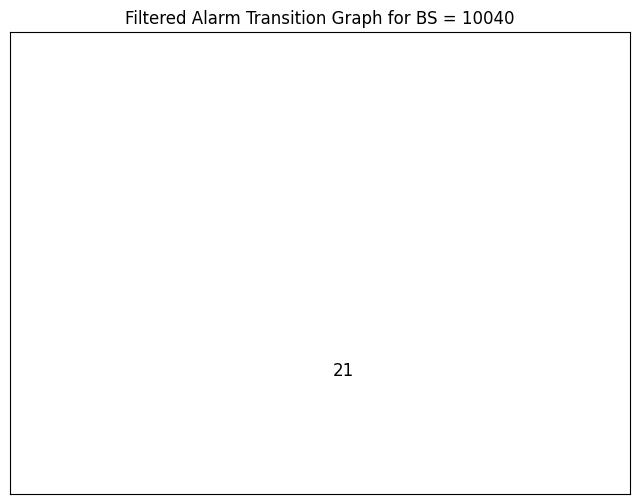

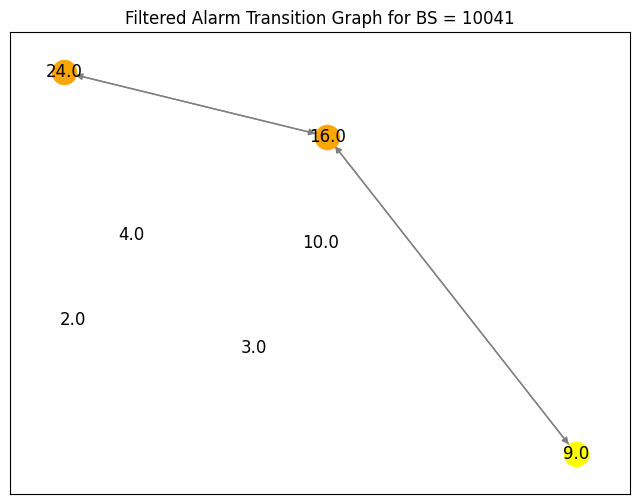

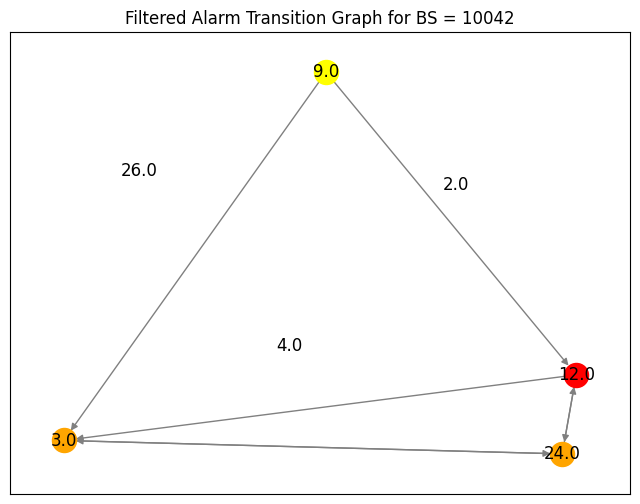

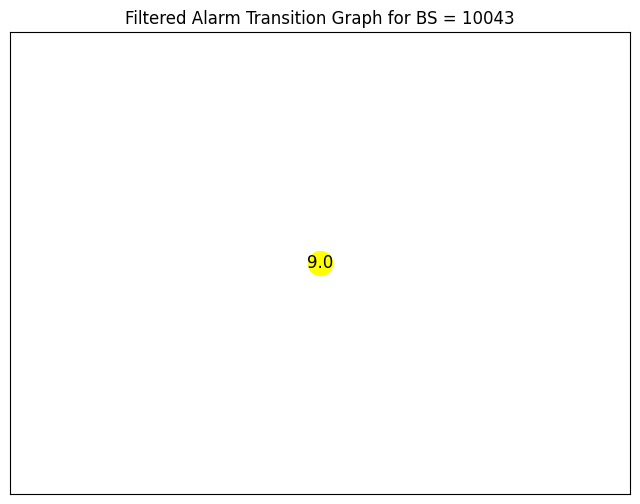

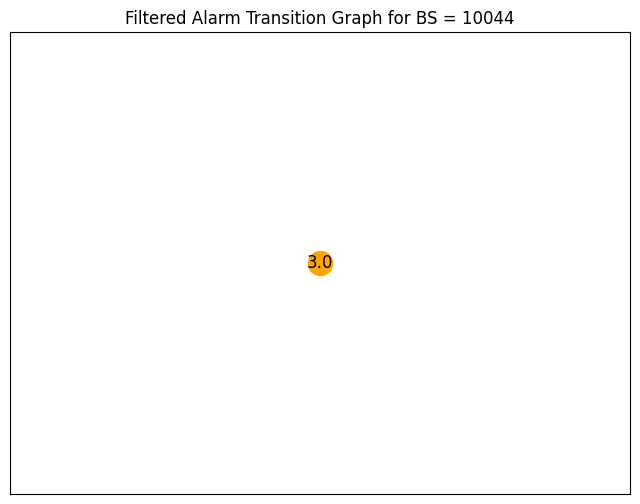

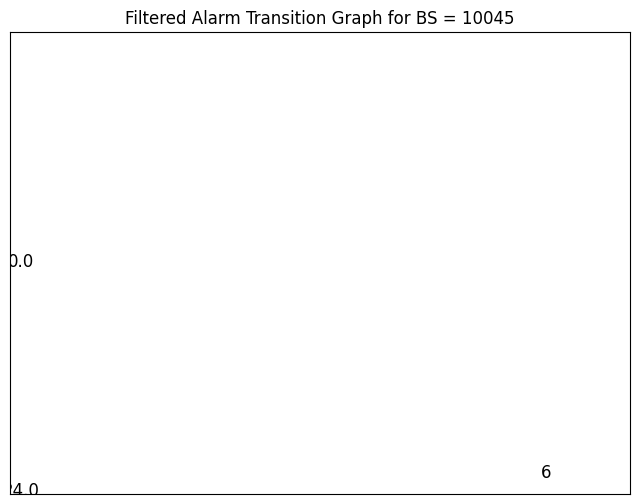

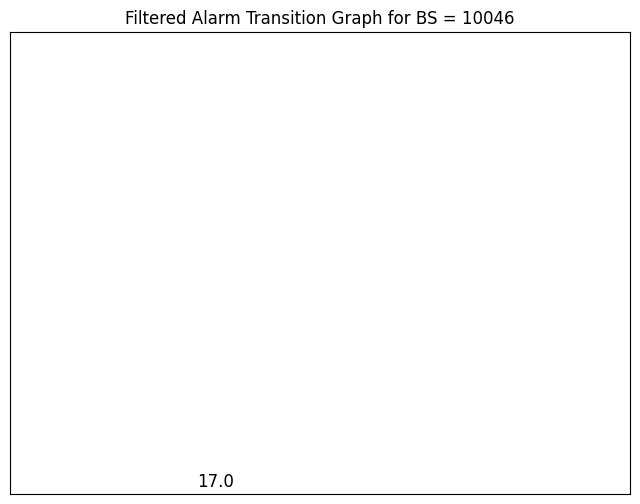

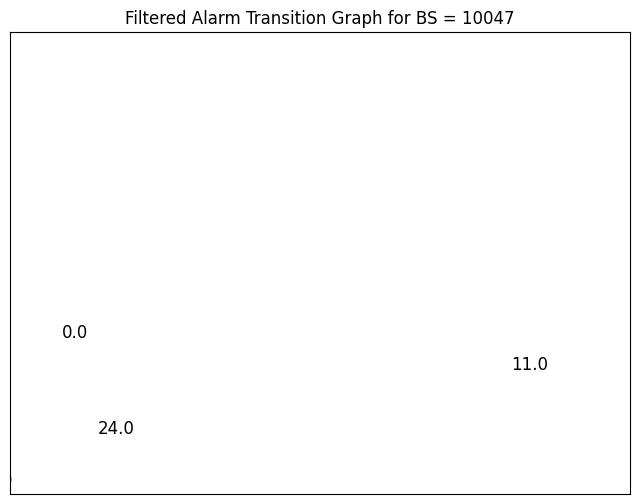

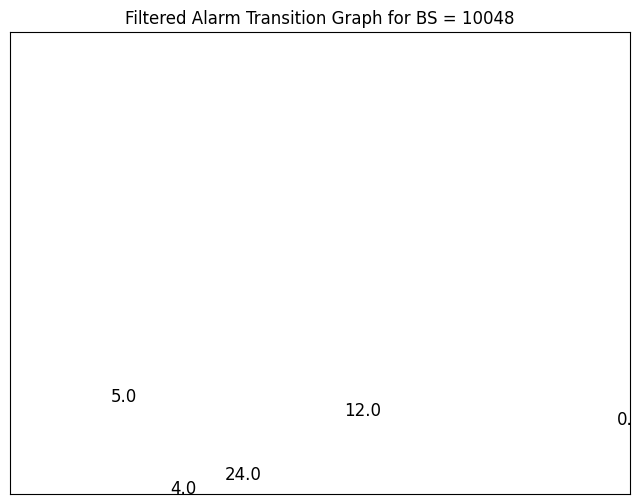

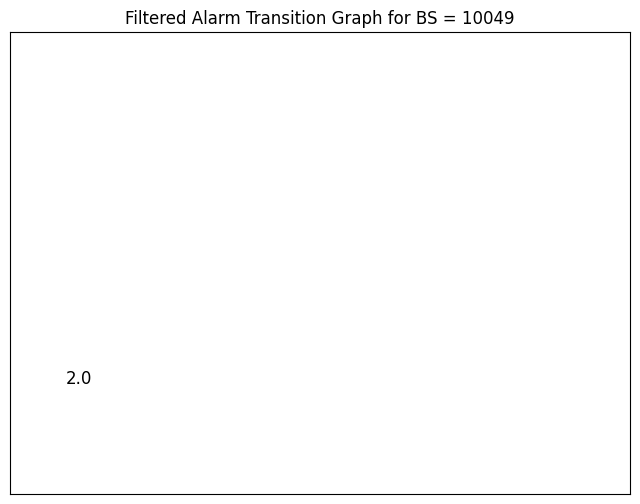

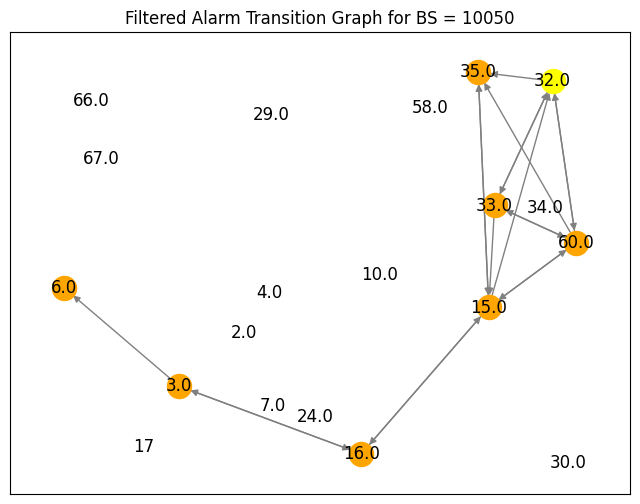

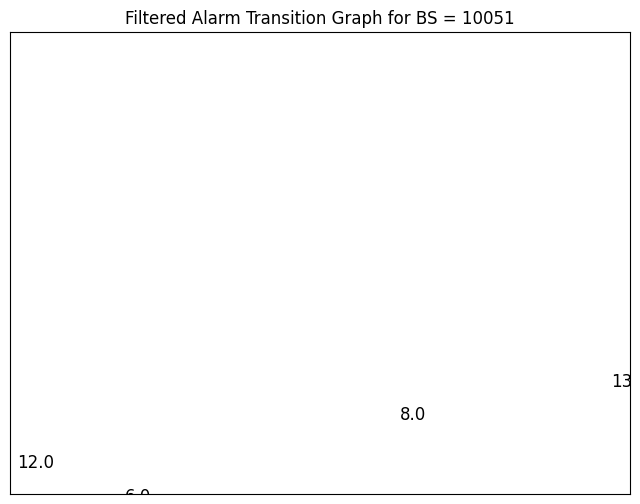

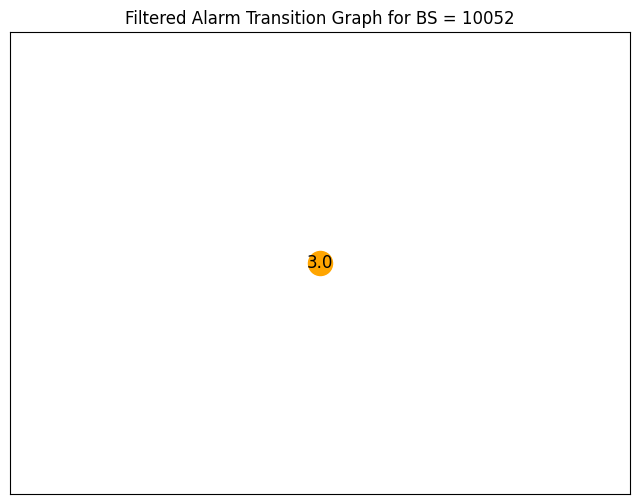

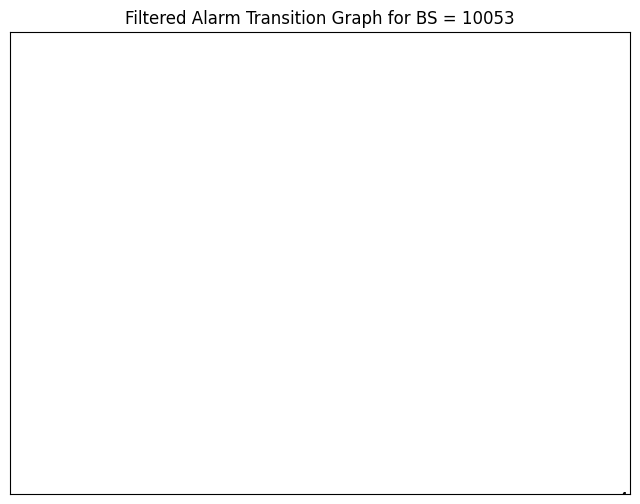

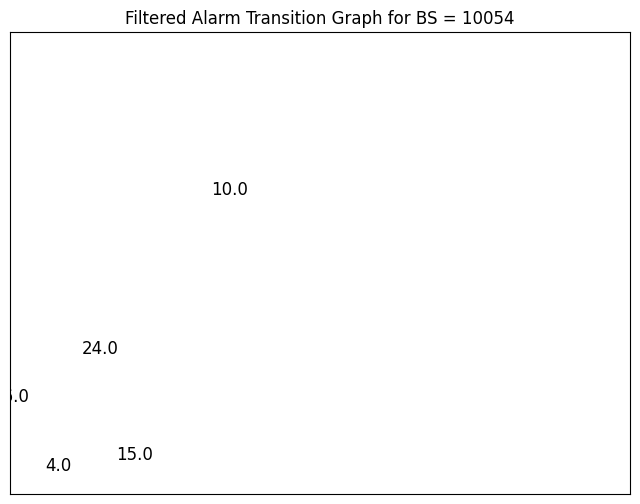

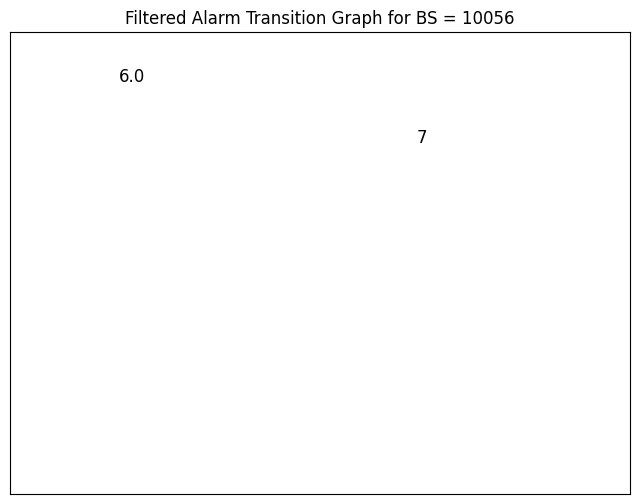

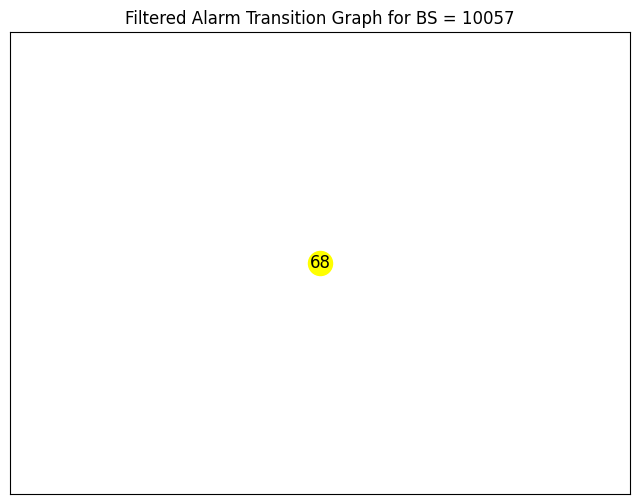

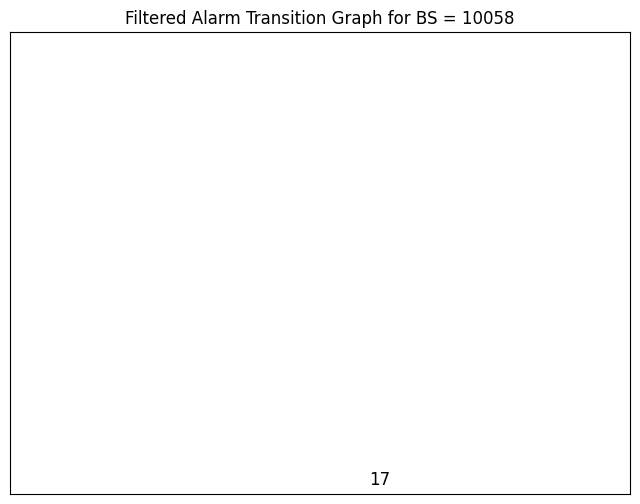

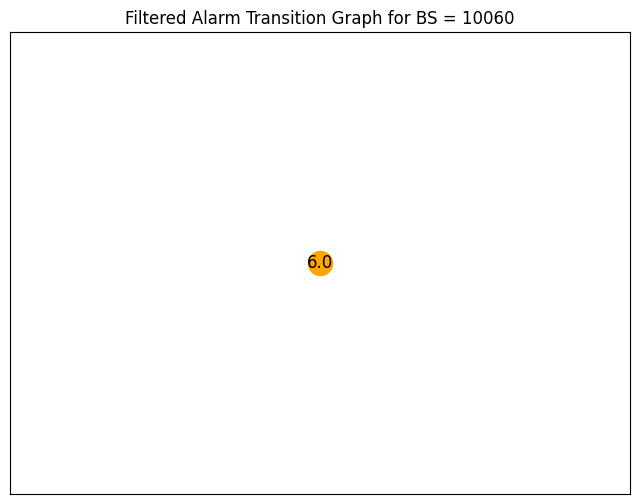

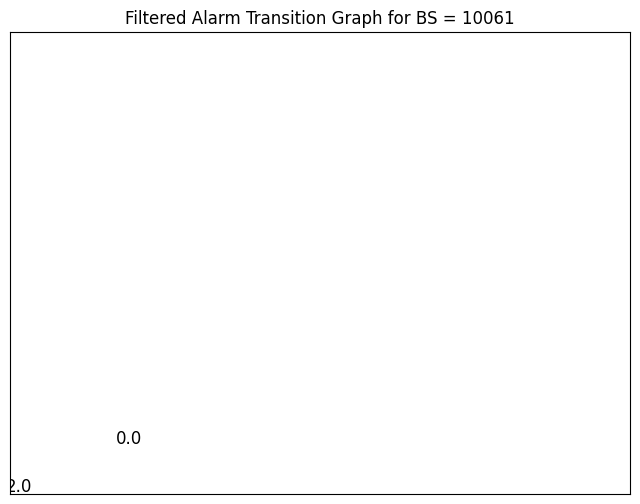

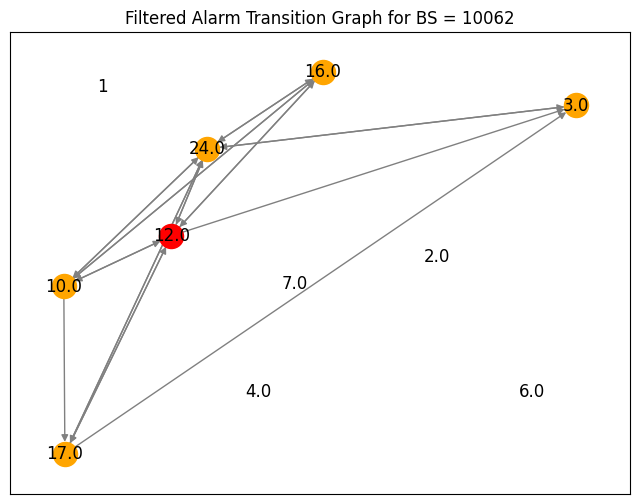

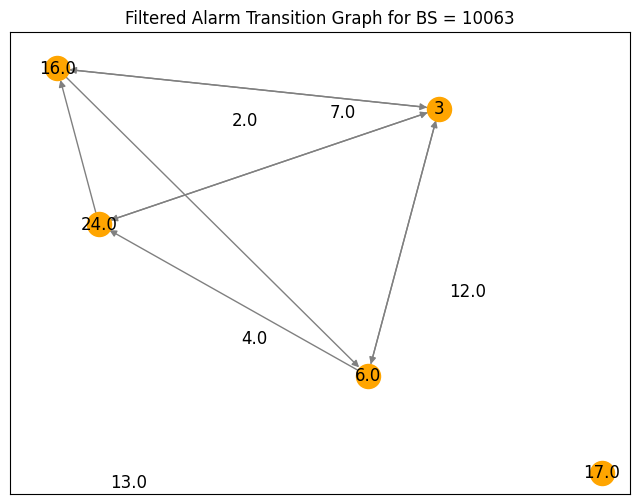

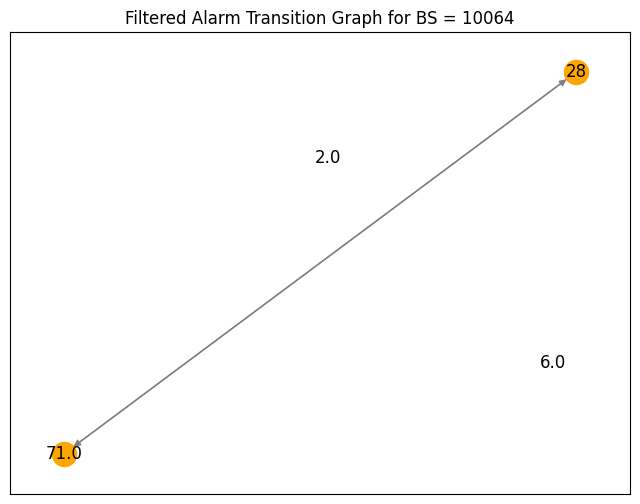

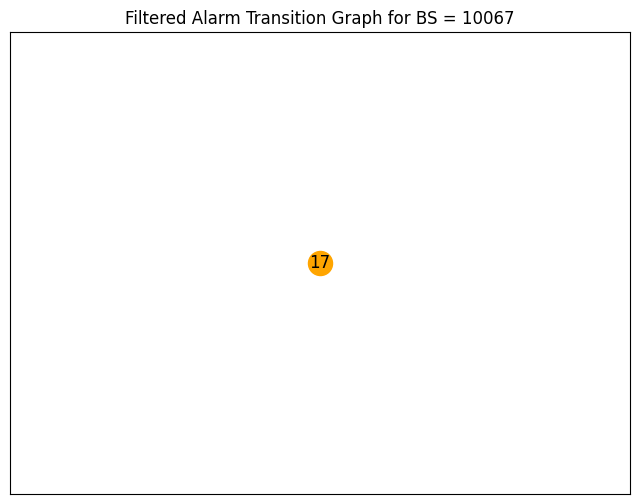

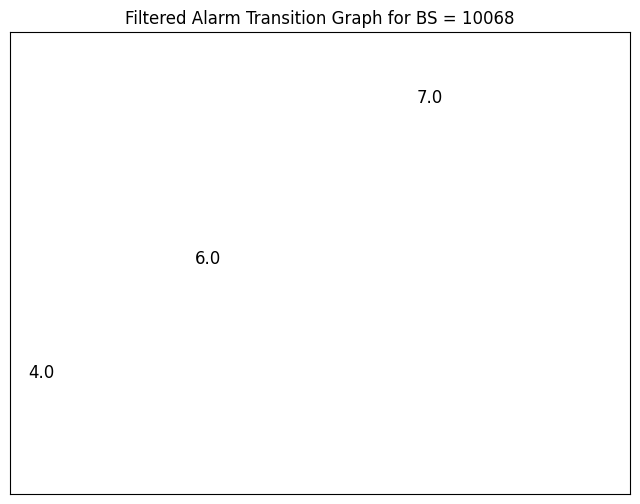

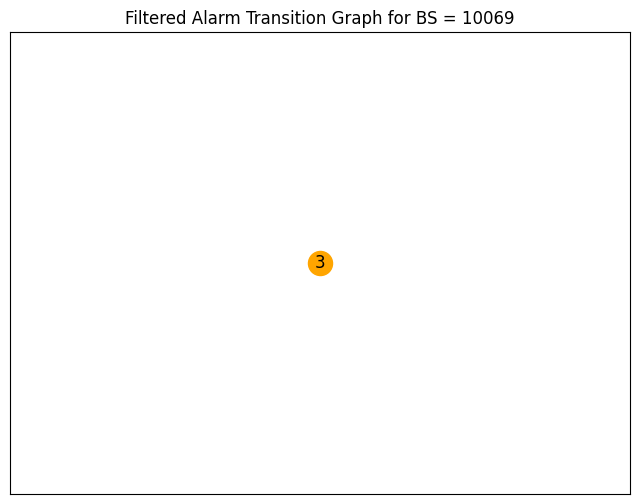

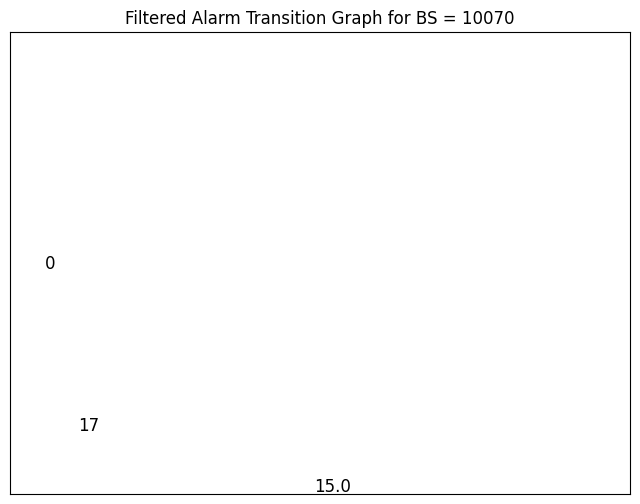

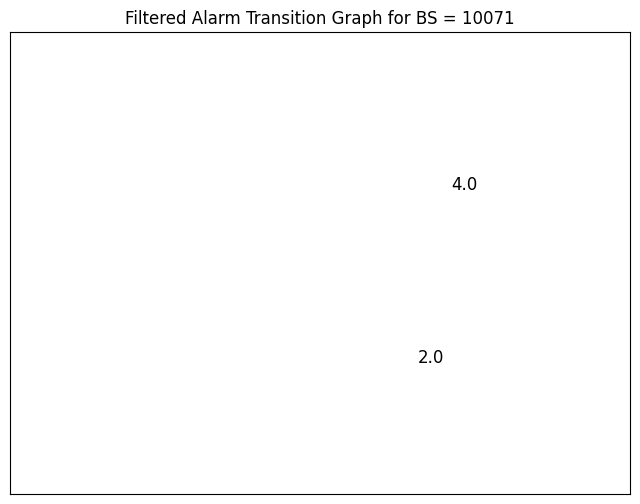

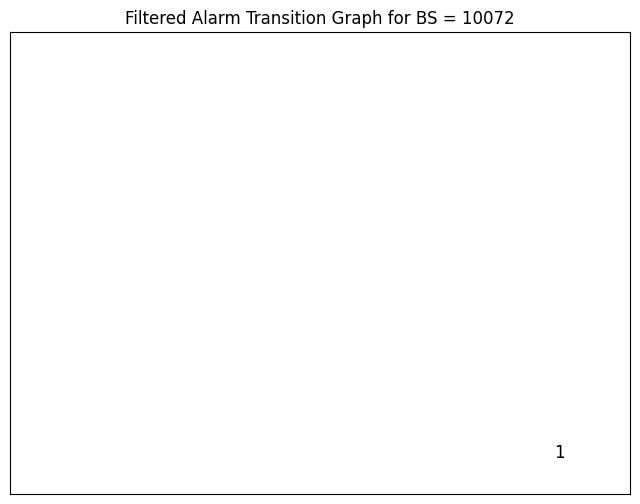

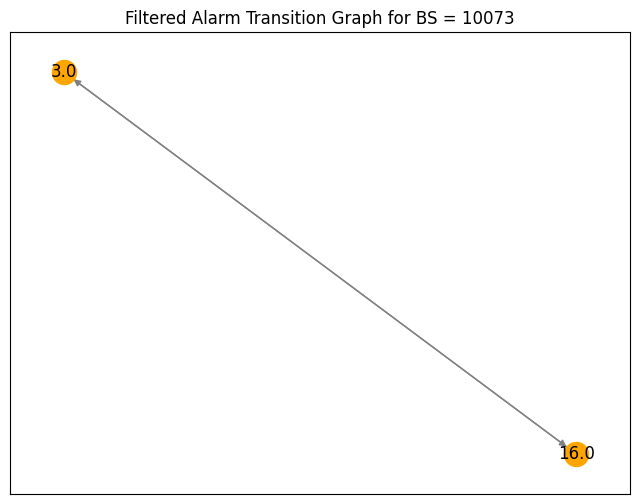

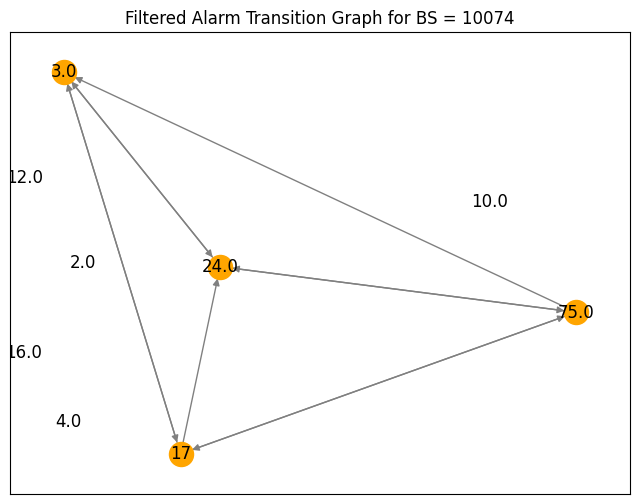

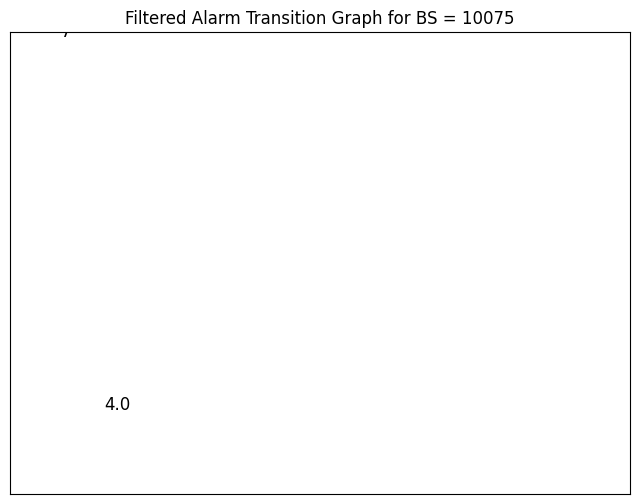

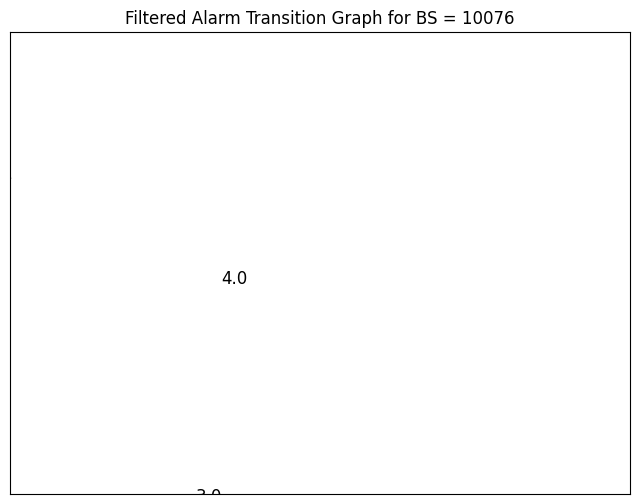

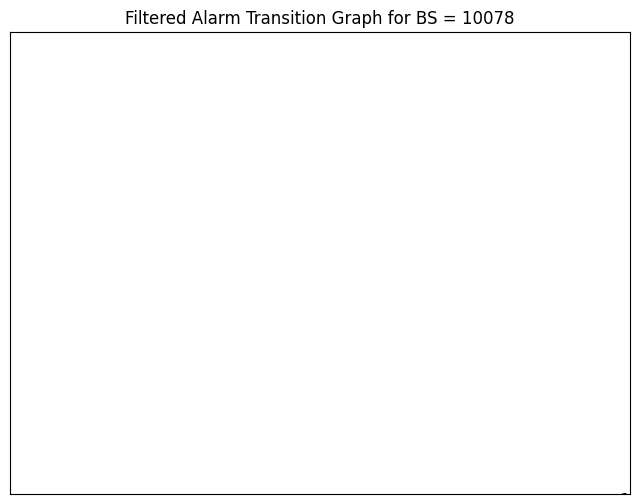

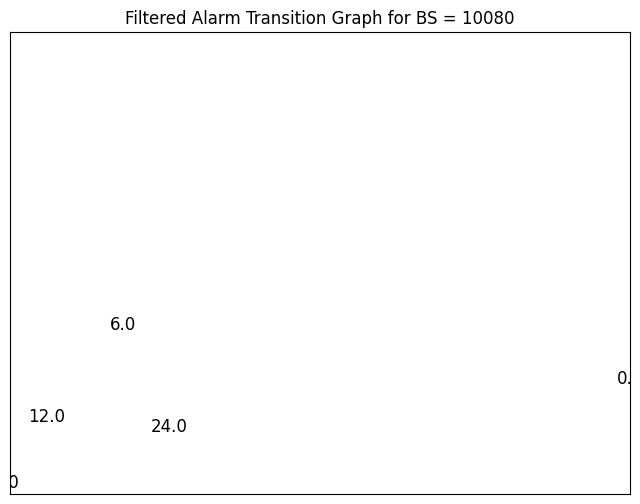

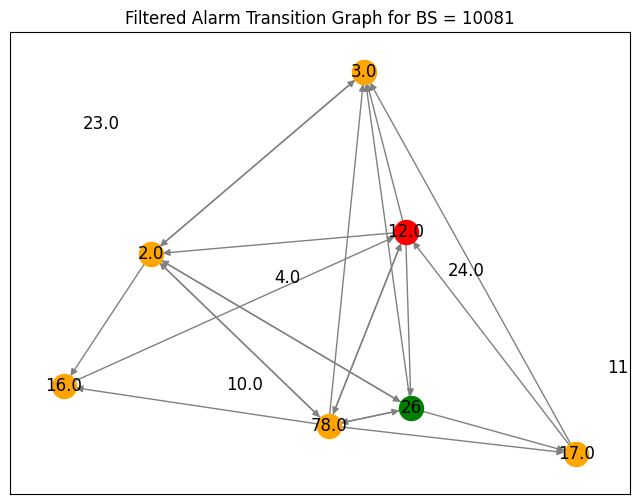

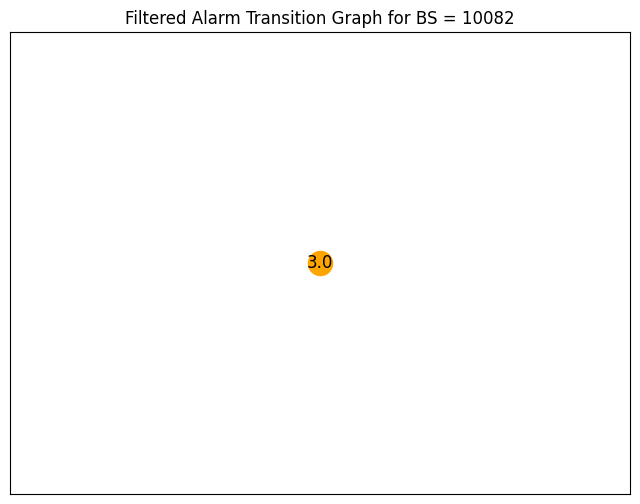

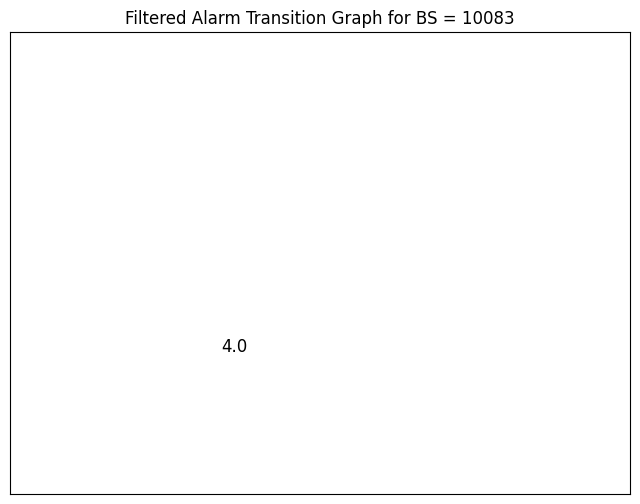

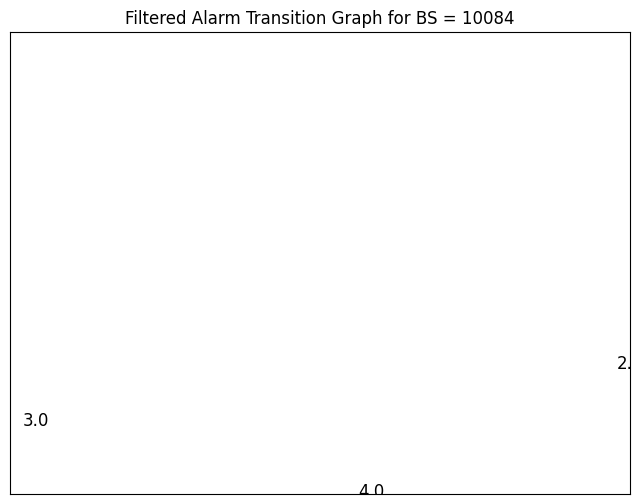

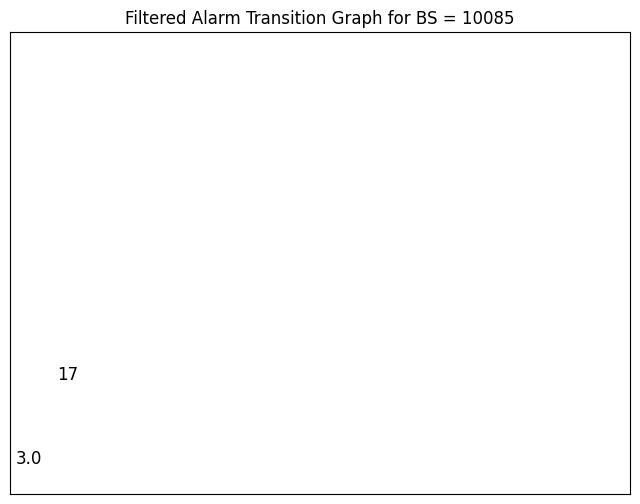

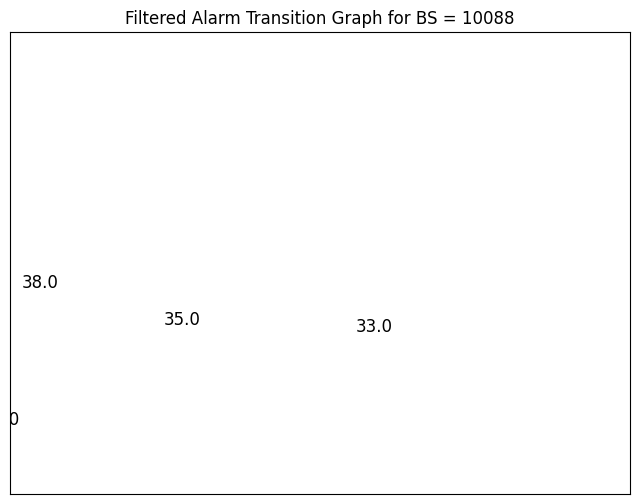

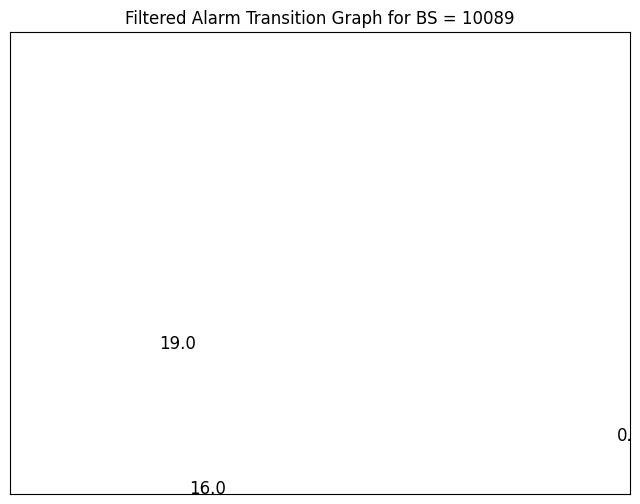

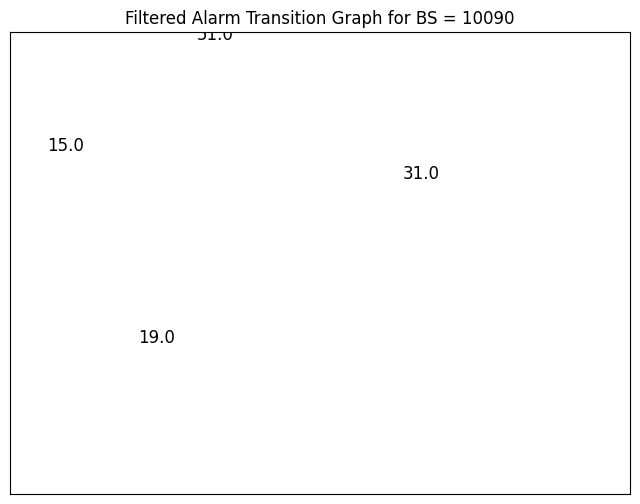

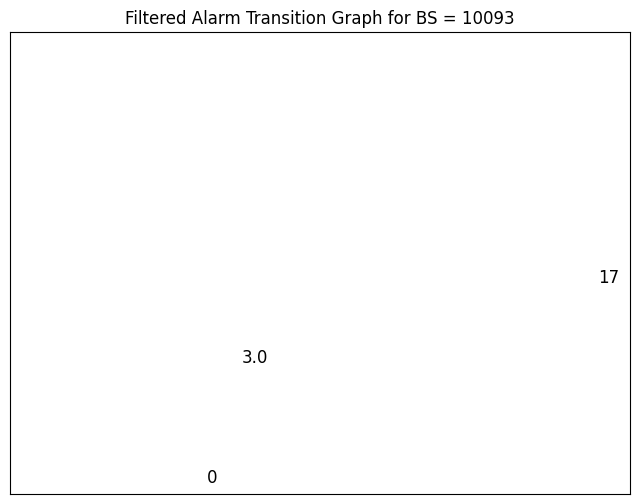

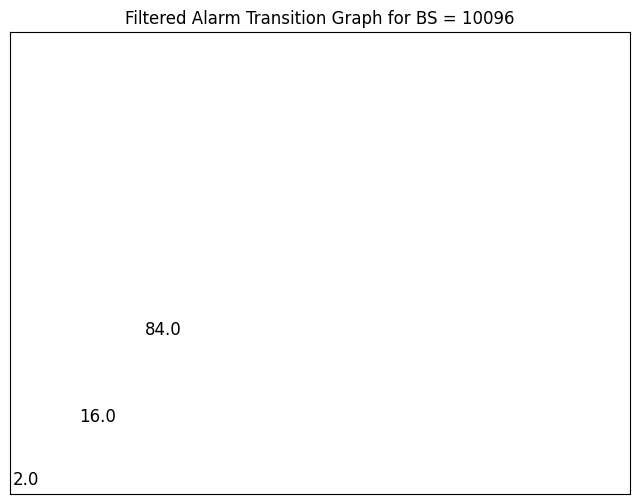

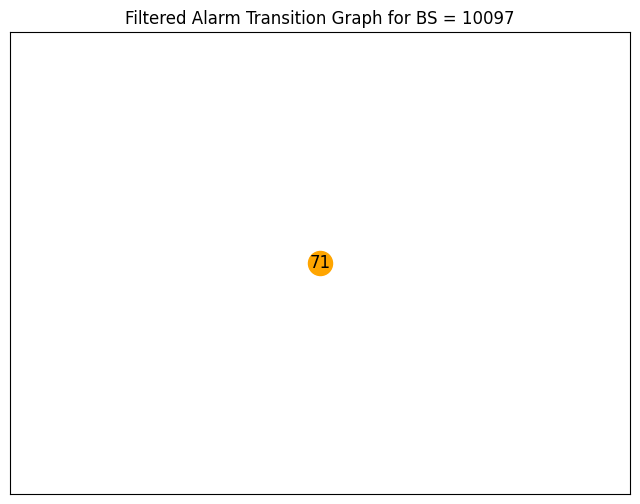

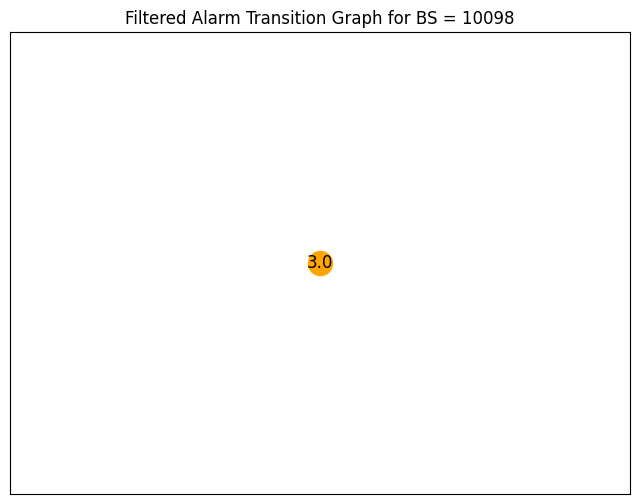

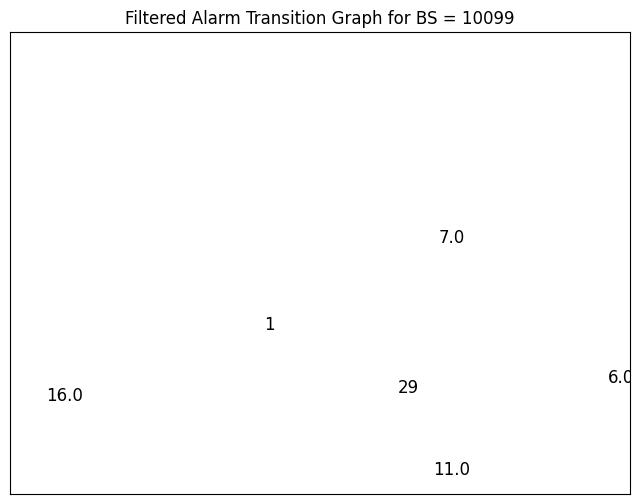

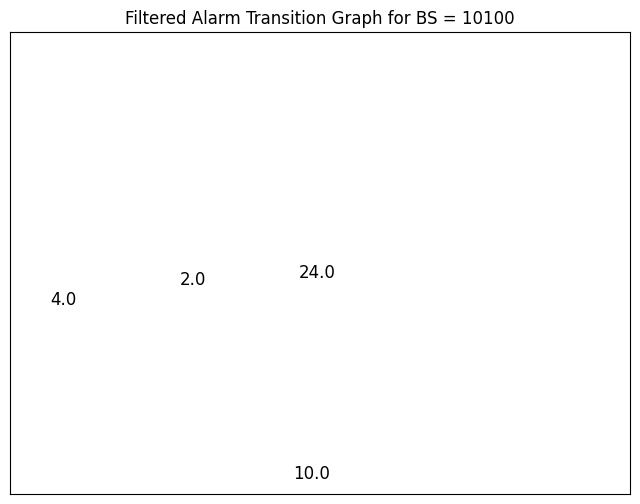

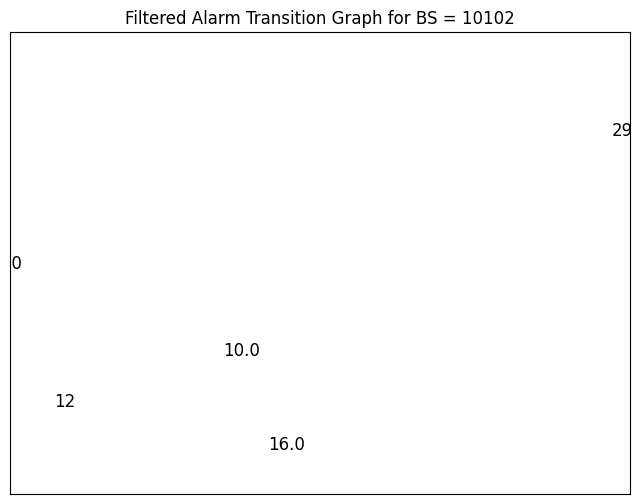

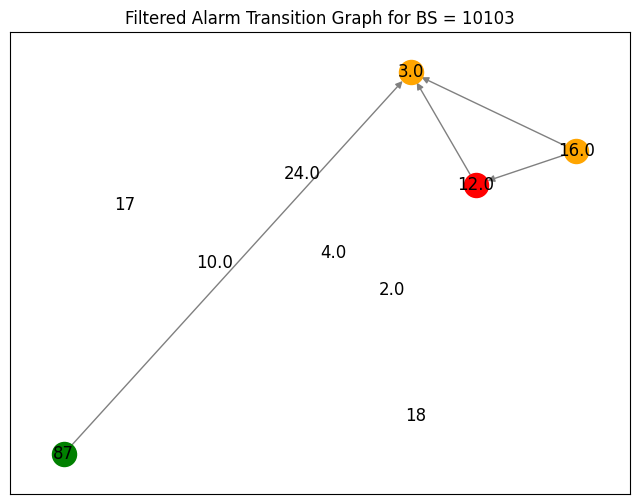

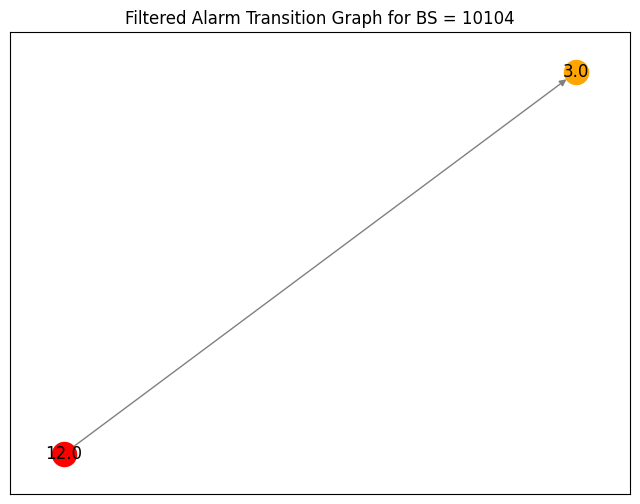

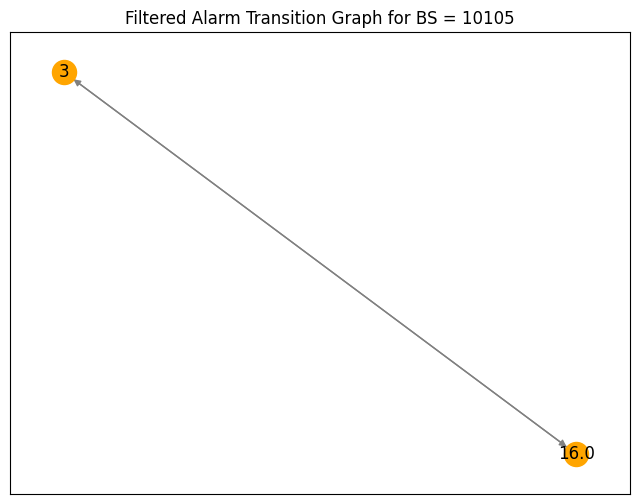

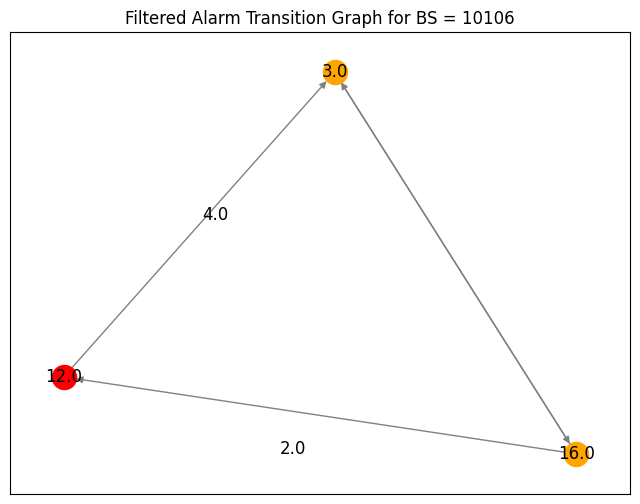

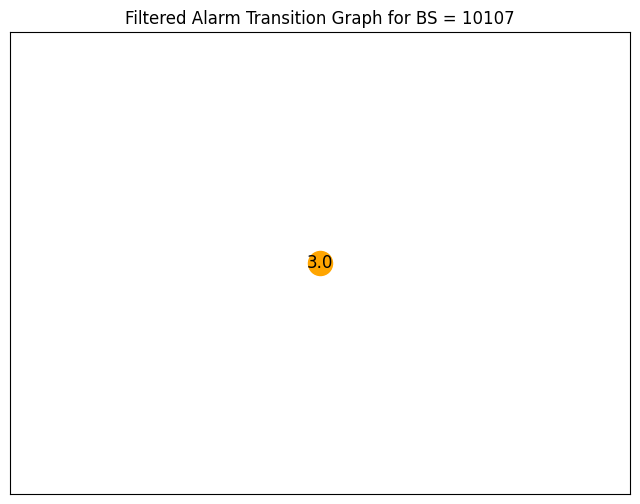

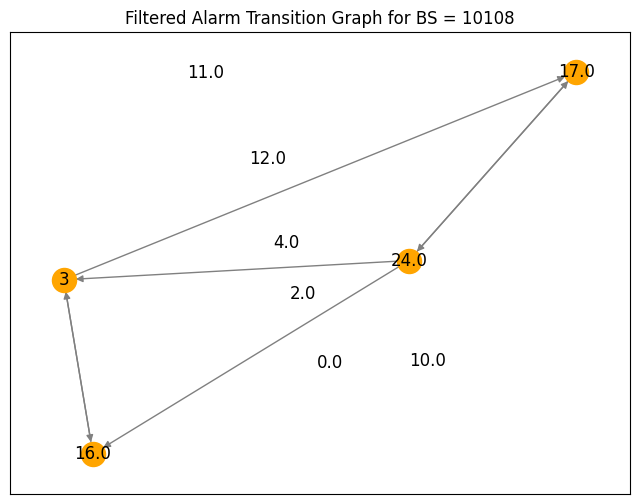

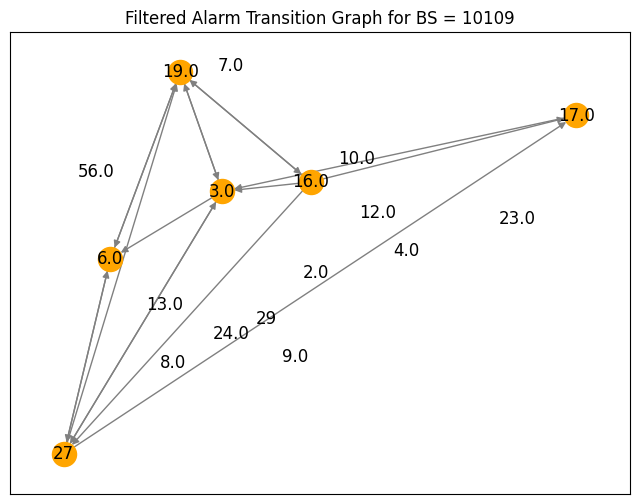

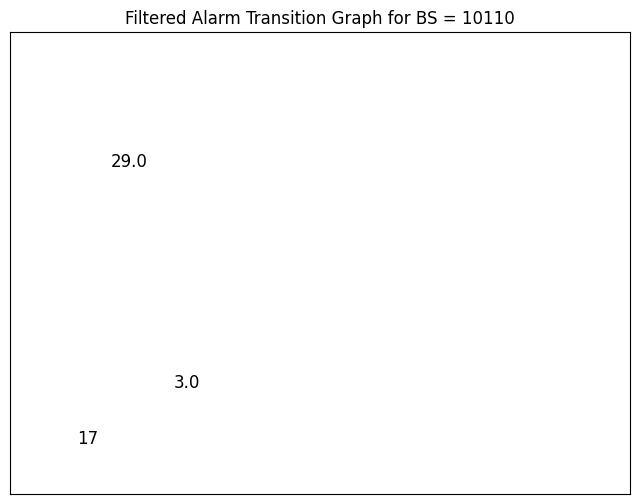

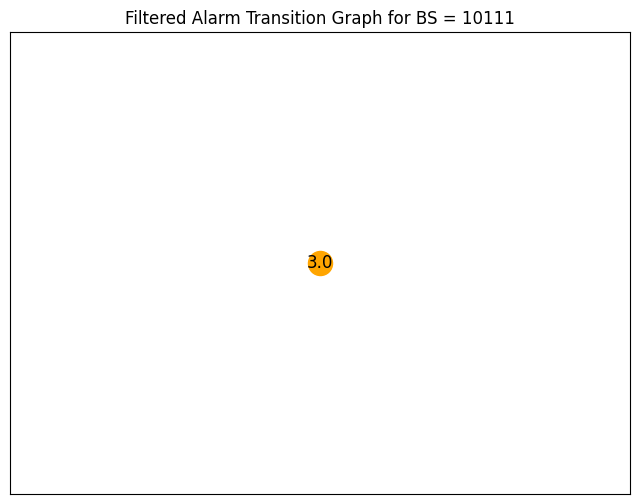

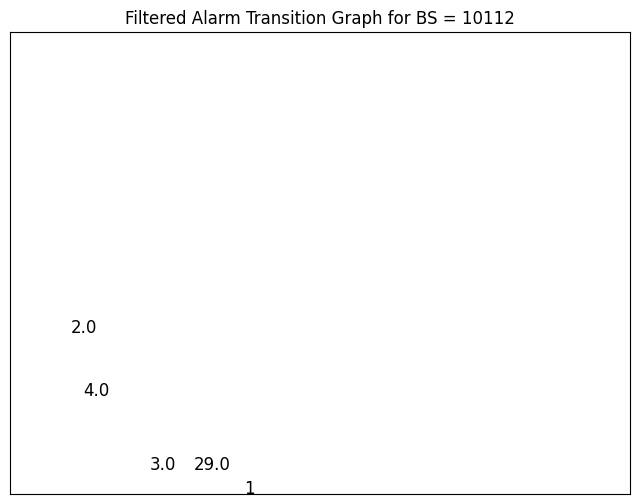

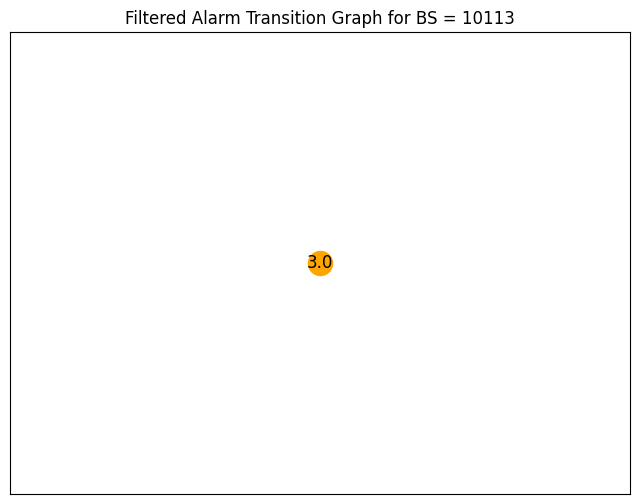

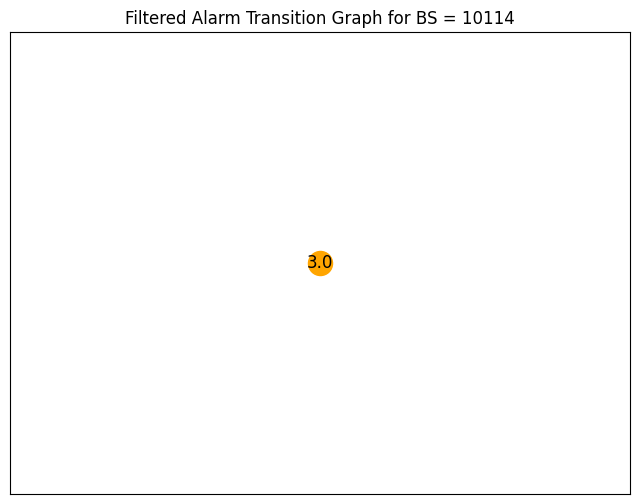

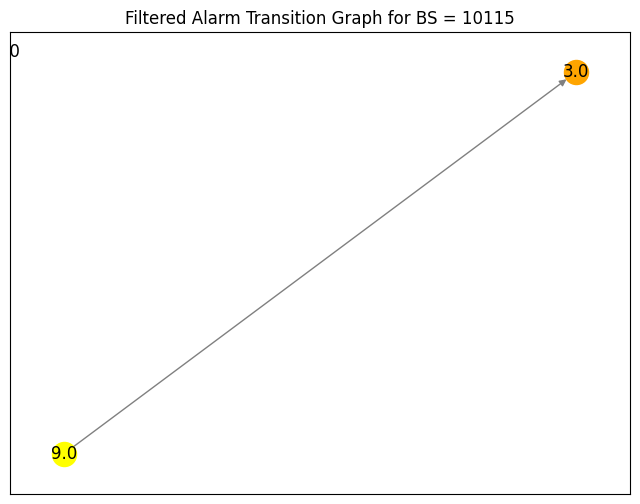

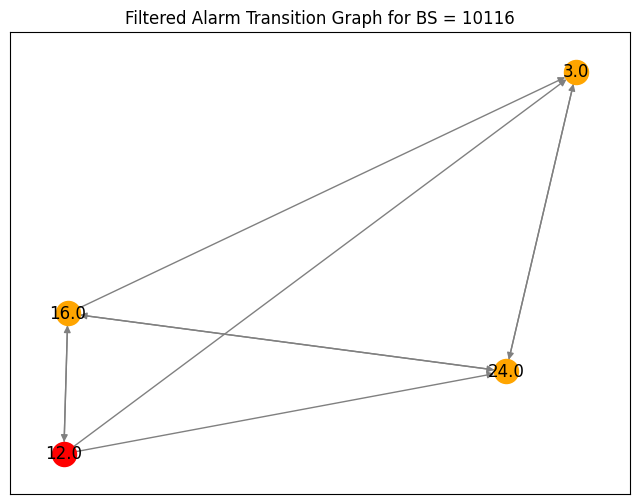

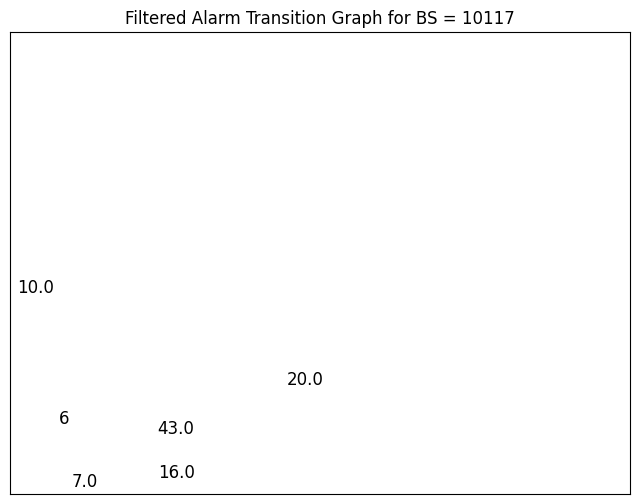

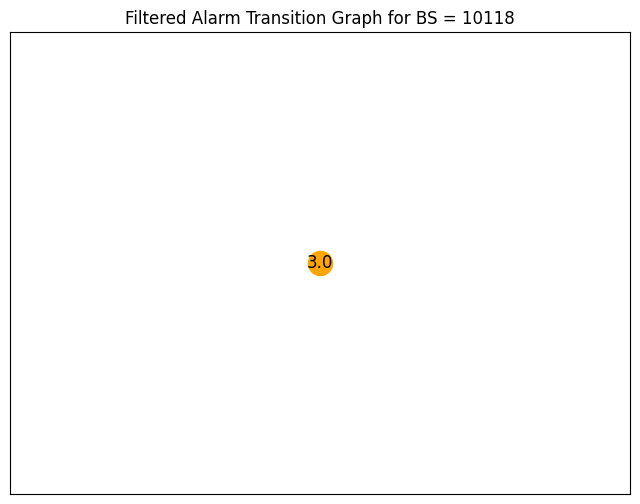

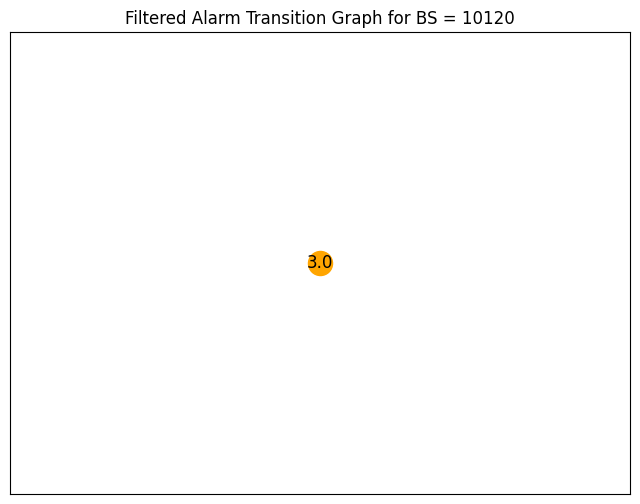

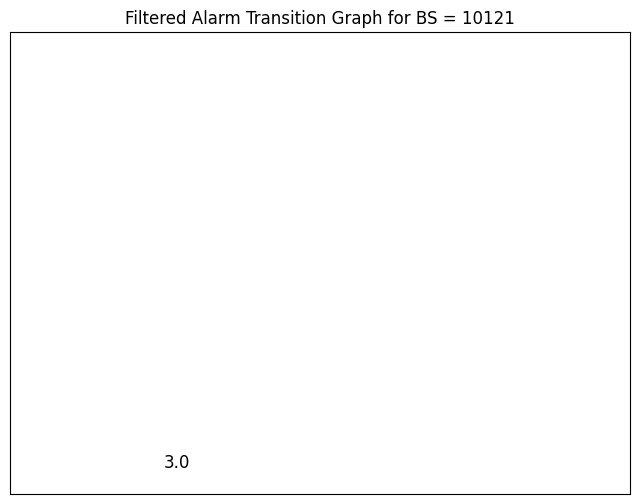

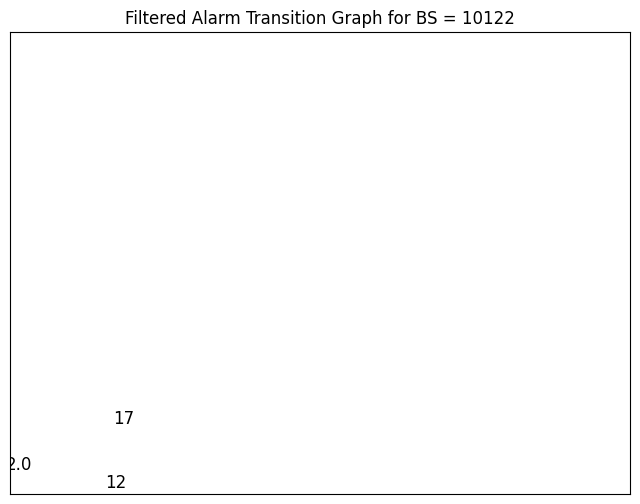

In [10]:
bs=df.loc[:,'Alarm Source'].unique()

# Use factorize to assign numbers to unique alarm names
labels, unique_values = pd.factorize(df['Name'])

# Map each alarm in the DataFrame to its assigned number
mapped_labels = labels[df['Name'].index]

# Create a DataFrame from the unique alarm names and their corresponding labels
alarm_name_number_df = pd.DataFrame({
    'Alarm_Name': df['Name'],
    'Alarm_Number': mapped_labels,
    'Severity': df['Severity']
})

os.makedirs('saved_graphs', exist_ok=True)

graph_data = []
shown_alarms = []  # List to keep track of shown alarms

check_degree = 5

for i in range(0, 100):
    G_filtered = nx.DiGraph()
    filtered_df = selected_df[selected_df['Alarm Source'] == bs[i]]

    for _, row in filtered_df.iterrows():
        if row['Next_Alarm_Number'] != 999:
            G_filtered.add_edge(row['Alarm_Number'], row['Next_Alarm_Number'])

    # Filter nodes with in-degree > 4
    nodes_to_plot = [node for node in G_filtered.nodes if G_filtered.in_degree(node) > check_degree]

    # Filter edges where both nodes are in nodes_to_plot
    edges_to_plot = [(u, v) for u, v in G_filtered.edges if u in nodes_to_plot and v in nodes_to_plot]

    # Define node colors and shapes for filtered nodes
    node_colors = [severity_colors.get(number_to_severity.get(node, 'Noalarm'), 'lightblue') for node in nodes_to_plot]
    node_shapes = ['s' if G_filtered.out_degree(node) == 0 else 'o' for node in nodes_to_plot]

    # Update shown_alarms list
    for u, v in edges_to_plot:
        shown_alarms.append((alarm_name_number_df.loc[u, 'Alarm_Name'], alarm_name_number_df.loc[v, 'Alarm_Name']))

    # Visualize the graph with different node shapes for filtered nodes
    plt.figure(figsize=(8, 6))  # Adjust the size as needed
    pos = nx.spring_layout(G_filtered)  # Position layout for nodes

    for node, shape in zip(nodes_to_plot, node_shapes):
        nx.draw_networkx_nodes(G_filtered, pos=pos, nodelist=[node],
                               node_color=[node_colors[nodes_to_plot.index(node)]],
                               node_shape=shape)

    nx.draw_networkx_edges(G_filtered, pos=pos, edgelist=edges_to_plot, edge_color='gray')
    nx.draw_networkx_labels(G_filtered, pos=pos, font_size=12)

    plt.title(f'Filtered Alarm Transition Graph for BS = {bs[i]}')
    plt.show()

    shown_alarms

In [11]:
# Processing the shown alarms to find unique alarms caused and map the causing alarms against each, with counts
caused_alarms = {}
for cause, effect in shown_alarms:
    if effect not in caused_alarms:
        caused_alarms[effect] = {}
    if cause not in caused_alarms[effect]:
        caused_alarms[effect][cause] = 0
    caused_alarms[effect][cause] += 1

# Output the caused_alarms dictionary with counts
for alarm, causes in caused_alarms.items():
    print(f"Alarm: {alarm}")
    for cause, count in causes.items():
        print(f"  Caused by: {cause}, Count: {count}")

# Convert the dictionary to include the counts in a readable format
caused_alarms_with_counts = {effect: [(cause, count) for cause, count in causes.items()]
                             for effect, causes in caused_alarms.items()}

caused_alarms_with_counts

Alarm: OML Fault
  Caused by: RF Unit Maintenance Link Failure, Count: 3
  Caused by: GSM Cell Manually Blocked, Count: 14
  Caused by: RF Unit DC Input Power Failure, Count: 12
  Caused by: Radio Signaling Link Disconnected, Count: 1
  Caused by: S1 Interface Fault, Count: 11
  Caused by: Board Hardware Fault, Count: 5
  Caused by: RF Unit RX Channel RTWP/RSSI Too Low, Count: 1
  Caused by: Cell Blocked, Count: 2
  Caused by: Remote Maintenance Link Failure, Count: 15
  Caused by: Cell RX Channel Interference Noise Power Unbalanced, Count: 2
  Caused by: GSM Cell out of Service, Count: 2
  Caused by: IP PM Activation Failure, Count: 5
  Caused by: ALD Maintenance Link Failure, Count: 2
Alarm: GSM Cell Manually Blocked
  Caused by: IP PM Activation Failure, Count: 11
  Caused by: RF Unit DC Input Power Failure, Count: 5
  Caused by: S1 Interface Fault, Count: 7
  Caused by: OML Fault, Count: 3
  Caused by: RF Unit RX Channel RTWP/RSSI Too Low, Count: 2
  Caused by: Cell Blocked, Count:

{'OML Fault': [('RF Unit Maintenance Link Failure', 3),
  ('GSM Cell Manually Blocked', 14),
  ('RF Unit DC Input Power Failure', 12),
  ('Radio Signaling Link Disconnected', 1),
  ('S1 Interface Fault', 11),
  ('Board Hardware Fault', 5),
  ('RF Unit RX Channel RTWP/RSSI Too Low', 1),
  ('Cell Blocked', 2),
  ('Remote Maintenance Link Failure', 15),
  ('Cell RX Channel Interference Noise Power Unbalanced', 2),
  ('GSM Cell out of Service', 2),
  ('IP PM Activation Failure', 5),
  ('ALD Maintenance Link Failure', 2)],
 'GSM Cell Manually Blocked': [('IP PM Activation Failure', 11),
  ('RF Unit DC Input Power Failure', 5),
  ('S1 Interface Fault', 7),
  ('OML Fault', 3),
  ('RF Unit RX Channel RTWP/RSSI Too Low', 2),
  ('Cell Blocked', 3),
  ('Remote Maintenance Link Failure', 11),
  ('Board Hardware Fault', 2),
  ('GSM Cell out of Service', 1),
  ('Cell RX Channel Interference Noise Power Unbalanced', 1),
  ('RF Unit Maintenance Link Failure', 1)],
 'RF Unit DC Input Power Failure': [(

In [12]:
import plotly.graph_objects as go


# Create a list of unique alarms (labels)
unique_alarms = set([alarm for effect, causes in caused_alarms_with_counts.items() for alarm, _ in causes])
unique_alarms.update(caused_alarms_with_counts.keys())
labels = list(unique_alarms)

# Map each alarm to an index
alarm_to_index = {alarm: i for i, alarm in enumerate(labels)}

# Initialize source, target, and value lists
source = []
target = []
value = []

# Populate the lists with data
for effect, causes in caused_alarms_with_counts.items():
    effect_idx = alarm_to_index[effect]
    for cause, count in causes:
        cause_idx = alarm_to_index[cause]
        source.append(cause_idx)
        target.append(effect_idx)
        value.append(count)

# Create Sankey diagram
fig = go.Figure(data=[go.Sankey(
    node=dict(
      pad=15,
      thickness=20,
      line=dict(color="black", width=0.5),
      label=labels
    ),
    link=dict(
      source=source,
      target=target,
      value=value
    ))])

fig.update_layout(title_text=f'Alarm Causality for in-degree > {check_degree}', font_size=12)
fig.show()

